In [1]:
# ============================================================================
# SECTION 0: ENVIRONMENT SETUP & IMPORTS
# ============================================================================

!pip install kagglehub pandas numpy scikit-learn xgboost lightgbm catboost matplotlib seaborn scipy imbalanced-learn -q

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pickle
import json

print("✓ All dependencies installed successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00
✓ All dependencies installed successfully


In [2]:
import kagglehub
import shutil # Import shutil for copying files

print("📥 Downloading complete UNSW-NB15 dataset from Kaggle...")
print("(This may take a few minutes depending on your internet speed)\n")

# This is the desired *final* location for the dataset in /content
target_content_path = '/content/unsw-nb15-dataset'

try:
    # Let kagglehub download to its default cache location.
    # The returned 'source_path' will be where kagglehub placed the files.
    source_path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")

    # Ensure the target directory in /content exists
    os.makedirs(target_content_path, exist_ok=True)

    print(f"✓ Dataset downloaded by KaggleHub to cache: {source_path}")
    print(f"   Copying files to user-specified location: {target_content_path}\n")

    # Copy all files from the KaggleHub cache to the user's desired /content location
    for item in os.listdir(source_path):
        s = os.path.join(source_path, item)
        d = os.path.join(target_content_path, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

    # Update the 'path' variable to reflect the new, user-desired location
    path = target_content_path
    print(f"✓ Dataset successfully copied to: {path}\n")

except Exception as e:
    print(f"✗ An error occurred during download or copy: {e}")
    print("Make sure you have Kaggle API configured and a stable internet connection!\n")
    # If an error occurred, 'path' might not be correctly set for listing files later.
    # Fallback to cache path if download succeeded but copy failed, or set to an invalid path.
    if 'source_path' in locals() and os.path.exists(source_path):
        path = source_path # Fallback to cache path if copy failed, but download succeeded
    else:
        path = '/invalid/path' # Indicate a complete failure


# List all files in the directory that 'path' now points to
print("Files in dataset directory (now in /content):")
if os.path.exists(path):
    files = os.listdir(path)
    for f in sorted(files):
        file_path = os.path.join(path, f)
        file_size_mb = os.path.getsize(file_path) / (1024**2)
        print(f"  - {f:<40} ({file_size_mb:>8.2f} MB)")
else:
    print("  (Dataset directory could not be found or created.)")
print()

📥 Downloading complete UNSW-NB15 dataset from Kaggle...
(This may take a few minutes depending on your internet speed)



100%|██████████| 149M/149M [00:01<00:00, 90.5MB/s]

Extracting files...


✓ Dataset downloaded by KaggleHub to cache: /root/.cache/kagglehub/datasets/mrwellsdavid/unsw-nb15/versions/1
   Copying files to user-specified location: /content/unsw-nb15-dataset

✓ Dataset successfully copied to: /content/unsw-nb15-dataset

Files in dataset directory (now in /content):
  - NUSW-NB15_features.csv                   (    0.00 MB)
  - UNSW-NB15_1.csv                          (  161.15 MB)
  - UNSW-NB15_2.csv                          (  157.57 MB)
  - UNSW-NB15_3.csv                          (  147.43 MB)
  - UNSW-NB15_4.csv                          (   93.07 MB)
  - UNSW-NB15_LIST_EVENTS.csv                (    0.00 MB)
  - UNSW_NB15_testing-set.csv                (   30.80 MB)
  - UNSW_NB15_training-set.csv               (   14.67 MB)



In [3]:
# ============================================================================
# SECTION 1: DEFINE EXACT 50-FEATURE CONFIGURATION
# ============================================================================

print("="*80)
print("SECTION 1: UNSW-NB15 50-FEATURE CONFIGURATION")
print("="*80 + "\n")

# EXACT 50 features as provided by user
EXACT_50_FEATURES = [
    'srcip',           # 1
    'sport',           # 2
    'dstip',           # 3
    'dsport',          # 4
    'proto',           # 5
    'state',           # 6
    'dur',             # 7
    'sbytes',          # 8
    'dbytes',          # 9
    'sttl',            # 10
    'dttl',            # 11
    'sloss',           # 12
    'dloss',           # 13
    'service',         # 14
    'Sload',           # 15
    'Dload',           # 16
    'Spkts',           # 17
    'Dpkts',           # 18
    'swin',            # 19
    'dwin',            # 20
    'stcpb',           # 21
    'dtcpb',           # 22
    'smeansz',         # 23
    'dmeansz',         # 24
    'trans_depth',     # 25
    'res_bdy_len',     # 26
    'Sjit',            # 27
    'Djit',            # 28
    'Stime',           # 29
    'Ltime',           # 30
    'Sintpkt',         # 31
    'Dintpkt',         # 32
    'tcprtt',          # 33
    'synack',          # 34
    'ackdat',          # 35
    'is_sm_ips_ports', # 36
    'ct_state_ttl',    # 37
    'ct_flw_http_mthd',# 38
    'is_ftp_login',    # 39
    'ct_ftp_cmd',      # 40
    'ct_srv_src',      # 41
    'ct_srv_dst',      # 42
    'ct_dst_ltm',      # 43
    'ct_src_ltm',      # 44
    'ct_src_dport_ltm',# 45
    'ct_dst_sport_ltm',# 46
    'ct_dst_src_ltm',  # 47
    'attack_cat',      # 48
    'Label'            # 49
]

print(f"UNSW-NB15 Exact Feature Set:")
print(f"  Total columns: {len(EXACT_50_FEATURES)}")
print(f"  Network features: 47 (columns 1-47)")
print(f"  Attack category: 1 (column 48) - attack_cat")
print(f"  Binary label: 1 (column 49) - Label")
print(f"\nAll {len(EXACT_50_FEATURES)} Columns:\n")

for i, feat in enumerate(EXACT_50_FEATURES, 1):
    if i <= 47:
        col_type = "NETWORK FEATURE"
    elif feat == 'attack_cat':
        col_type = "ATTACK CATEGORY"
    else:
        col_type = "BINARY LABEL"
    print(f"  {i:2d}. {feat:<20} [{col_type}]")

print(f"\n✓ Configuration: 47 ML features + 1 attack_cat + 1 Label = {len(EXACT_50_FEATURES)} total columns")
print(f"   (Note: srcip, dstip will be dropped before training)")
print(f"   Therefore: 45 ML features used for training\n")


SECTION 1: UNSW-NB15 50-FEATURE CONFIGURATION

UNSW-NB15 Exact Feature Set:
  Total columns: 49
  Network features: 47 (columns 1-47)
  Attack category: 1 (column 48) - attack_cat
  Binary label: 1 (column 49) - Label

All 49 Columns:

   1. srcip                [NETWORK FEATURE]
   2. sport                [NETWORK FEATURE]
   3. dstip                [NETWORK FEATURE]
   4. dsport               [NETWORK FEATURE]
   5. proto                [NETWORK FEATURE]
   6. state                [NETWORK FEATURE]
   7. dur                  [NETWORK FEATURE]
   8. sbytes               [NETWORK FEATURE]
   9. dbytes               [NETWORK FEATURE]
  10. sttl                 [NETWORK FEATURE]
  11. dttl                 [NETWORK FEATURE]
  12. sloss                [NETWORK FEATURE]
  13. dloss                [NETWORK FEATURE]
  14. service              [NETWORK FEATURE]
  15. Sload                [NETWORK FEATURE]
  16. Dload                [NETWORK FEATURE]
  17. Spkts                [NETWORK FEATURE]

In [4]:
# ============================================================================
# SECTION 2: SET DATA PATH TO /content/data
# ============================================================================

print("="*80)
print("SECTION 2: SETTING DATA PATH TO /content/data")
print("="*80 + "\n")

# Use /content/data path where data is already downloaded in Colab
data_path = '/content/data'

print(f"Data path: {data_path}")

# Check if path exists
if os.path.exists(data_path):
    print(f"✓ Path exists: {data_path}\n")
else:
    print(f"⚠ Path does not exist yet, creating it...")
    os.makedirs(data_path, exist_ok=True)
    print(f"✓ Created: {data_path}\n")

# List all files in data directory
print("Files in /content/data directory:")
if os.path.exists(data_path):
    files = os.listdir(data_path)
    if files:
        for f in sorted(files):
            file_path = os.path.join(data_path, f)
            if os.path.isfile(file_path):
                file_size_mb = os.path.getsize(file_path) / (1024**2)
                print(f"  - {f:<40} ({file_size_mb:>8.2f} MB)")
        print()
    else:
        print("  (Directory is empty)")
else:
    print(f"  (Path does not exist)\n")

path = data_path

SECTION 2: SETTING DATA PATH TO /content/data

Data path: /content/data
⚠ Path does not exist yet, creating it...
✓ Created: /content/data

Files in /content/data directory:
  (Directory is empty)


In [5]:
# ============================================================================
# SECTION 3: LOAD FEATURE NAMES FROM UNSW-NB15_features.csv
# ============================================================================

print("="*80)
print("SECTION 3: LOADING FEATURE NAMES FROM UNSW-NB15_features.csv")
print("="*80 + "\n")

features_file = os.path.join(path, 'NUSW-NB15_features.csv')

if os.path.exists(features_file):
    print(f"Loading features from: {features_file}")
    try:
        # Try reading with 'utf-8' first (pandas default)
        features_df = pd.read_csv(features_file, header=None, encoding='utf-8')
    except UnicodeDecodeError:
        # If 'utf-8' fails, try 'latin1'
        print("\n⚠ UnicodeDecodeError with 'utf-8', trying 'latin1' encoding...")
        features_df = pd.read_csv(features_file, header=None, encoding='latin1')

    # Correctly extract feature names from the 'Name' column (index 1) starting from the second row (index 1)
    feature_names_from_file = features_df.iloc[1:, 1].tolist()
    print(f"✓ Loaded {len(feature_names_from_file)} feature names from CSV\n")

    # Use the loaded names if available
    feature_names = feature_names_from_file
else:
    print(f"⚠ Features file not found at {features_file}")
    print(f"   Using exact 50-column configuration\n")
    feature_names = EXACT_50_FEATURES

print(f"Feature names being used ({len(feature_names)} columns):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")
print()

SECTION 3: LOADING FEATURE NAMES FROM UNSW-NB15_features.csv

Loading features from: /content/data/NUSW-NB15_features.csv

⚠ UnicodeDecodeError with 'utf-8', trying 'latin1' encoding...
✓ Loaded 49 feature names from CSV

Feature names being used (49 columns):
   1. srcip
   2. sport
   3. dstip
   4. dsport
   5. proto
   6. state
   7. dur
   8. sbytes
   9. dbytes
  10. sttl
  11. dttl
  12. sloss
  13. dloss
  14. service
  15. Sload
  16. Dload
  17. Spkts
  18. Dpkts
  19. swin
  20. dwin
  21. stcpb
  22. dtcpb
  23. smeansz
  24. dmeansz
  25. trans_depth
  26. res_bdy_len
  27. Sjit
  28. Djit
  29. Stime
  30. Ltime
  31. Sintpkt
  32. Dintpkt
  33. tcprtt
  34. synack
  35. ackdat
  36. is_sm_ips_ports
  37. ct_state_ttl
  38. ct_flw_http_mthd
  39. is_ftp_login
  40. ct_ftp_cmd
  41. ct_srv_src
  42. ct_srv_dst
  43. ct_dst_ltm
  44. ct_src_ ltm
  45. ct_src_dport_ltm
  46. ct_dst_sport_ltm
  47. ct_dst_src_ltm
  48. attack_cat
  49. Label



In [6]:
# ============================================================================
# SECTION 4: LOAD TRAINING DATA (UNSW-NB15_1.csv + UNSW-NB15_2.csv)
# ============================================================================

print("="*80)
print("SECTION 4: LOADING TRAINING DATA FILES")
print("="*80 + "\n")

training_files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv']
dfs_train = []

for csv_file in training_files:
    file_path = os.path.join(path, csv_file)

    if os.path.exists(file_path):
        file_size_mb = os.path.getsize(file_path) / (1024**2)
        print(f"Loading {csv_file} ({file_size_mb:.2f} MB)...")

        df_chunk = pd.read_csv(file_path, header=None, names=feature_names)

        print(f"  ✓ Shape: {df_chunk.shape}")
        print(f"  ✓ Columns: {df_chunk.shape[1]}")
        print(f"  ✓ Memory: {df_chunk.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

        dfs_train.append(df_chunk)
    else:
        print(f"  ✗ File not found: {csv_file}")
        print(f"     Expected at: {file_path}\n")

if dfs_train:
    print(f"\nConcatenating {len(dfs_train)} training files...")
    df_train = pd.concat(dfs_train, ignore_index=True)
    print(f"\n✓ Training files concatenated successfully!")
    print(f"  - Total samples: {df_train.shape[0]:,}")
    print(f"  - Total columns: {df_train.shape[1]}")
    print(f"  - Memory: {df_train.memory_usage(deep=True).sum() / (1024**2):.2f} MB\n")
else:
    print("✗ No training files found!\n")

print("Training Data Sample (first 3 rows):")
print(df_train.head(3))
print()


SECTION 4: LOADING TRAINING DATA FILES

Loading UNSW-NB15_1.csv (161.15 MB)...
  ✓ Shape: (700001, 49)
  ✓ Columns: 49
  ✓ Memory: 476.49 MB
Loading UNSW-NB15_2.csv (157.57 MB)...
  ✓ Shape: (700001, 49)
  ✓ Columns: 49
  ✓ Memory: 483.67 MB

Concatenating 2 training files...

✓ Training files concatenated successfully!
  - Total samples: 1,400,002
  - Total columns: 49
  - Memory: 997.54 MB

Training Data Sample (first 3 rows):
        srcip  sport          dstip dsport proto state       dur  sbytes  \
0  59.166.0.0   1390  149.171.126.6     53   udp   CON  0.001055     132   
1  59.166.0.0  33661  149.171.126.9   1024   udp   CON  0.036133     528   
2  59.166.0.6   1464  149.171.126.7     53   udp   CON  0.001119     146   

   dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0     164    31  ...           0           3           7          1   
1     304    31  ...           0           2           4          2   
2     178    31  ...           0          12     

In [7]:
# ============================================================================
# SECTION 5: LOAD TEST DATA (UNSW_NB15_testing-set.csv)
# ============================================================================

print("="*80)
print("SECTION 5: LOADING TEST DATA")
print("="*80 + "\n")

test_file = 'UNSW_NB15_testing-set.csv'
test_path = os.path.join(path, test_file)

if os.path.exists(test_path):
    file_size_mb = os.path.getsize(test_path) / (1024**2)
    print(f"Loading {test_file} ({file_size_mb:.2f} MB)...")

    try:
        df_test = pd.read_csv(test_path, header=None, names=feature_names)
        print(f"✓ Loaded as raw data (no headers)\n")
    except Exception as e:
        print(f"Attempting alternative load method...")
        df_test = pd.read_csv(test_path)
        print(f"✓ Loaded with existing headers\n")

    print(f"Test Set Information:")
    print(f"  - Total samples: {df_test.shape[0]:,}")
    print(f"  - Total columns: {df_test.shape[1]}")
    print(f"  - Memory: {df_test.memory_usage(deep=True).sum() / (1024**2):.2f} MB\n")
else:
    print(f"✗ Test file not found at: {test_path}\n")

print("Test Data Sample (first 3 rows):")
print(df_test.head(3))
print()

SECTION 5: LOADING TEST DATA

Loading UNSW_NB15_testing-set.csv (30.80 MB)...
✓ Loaded as raw data (no headers)

Test Set Information:
  - Total samples: 175,342
  - Total columns: 49
  - Memory: 291.90 MB

Test Data Sample (first 3 rows):
  srcip     sport  dstip   dsport  proto  state    dur  sbytes  dbytes  \
0    id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes   
1     1  0.121478    tcp        -    FIN      6      4     258     172   
2     2  0.649902    tcp        -    FIN     14     38     734   42014   

        sttl  ...        ct_ftp_cmd  ct_srv_src  ct_srv_dst       ct_dst_ltm  \
0       rate  ...  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports   
1   74.08749  ...                 0           1           1                0   
2  78.473372  ...                 0           1           6                0   

  ct_src_ ltm ct_src_dport_ltm ct_dst_sport_ltm ct_dst_src_ltm attack_cat  \
0  attack_cat            label              NaN            NaN   

In [8]:
# ============================================================================
# SECTION 6: IDENTIFY TARGET AND DATA TYPES
# ============================================================================

print("="*80)
print("SECTION 6: TARGET LABEL SELECTION & DATA TYPE IDENTIFICATION")
print("="*80 + "\n")

# Check for label column - use 'Label' (binary) not 'attack_cat' (multi-class)
if 'Label' in df_train.columns:
    target_col = 'Label'
    print("Using 'Label' column (binary: 0=Normal, 1=Attack)")
elif 'label' in df_train.columns:
    target_col = 'label'
    print("Using 'label' column (binary)")
else:
    target_col = df_train.columns[-1]
    print(f"Using last column as target: '{target_col}'")

print(f"Target column: '{target_col}'")
print(f"Target data type: {df_train[target_col].dtype}\n")

print("Training Set - Target Distribution:")
print(df_train[target_col].value_counts())
print()

print("Test Set - Target Distribution:")
print(df_test[target_col].value_counts())
print()

# Identify column types
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Remove target
if target_col in numerical_cols:
    numerical_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

# Also remove attack_cat if present
if 'attack_cat' in categorical_cols:
    categorical_cols.remove('attack_cat')
    print("Note: 'attack_cat' column removed (using binary 'Label' instead)\n")

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Total ML features: {len(categorical_cols) + len(numerical_cols)}\n")

SECTION 6: TARGET LABEL SELECTION & DATA TYPE IDENTIFICATION

Using 'Label' column (binary: 0=Normal, 1=Attack)
Target column: 'Label'
Target data type: int64

Training Set - Target Distribution:
Label
0    1325038
1      74964
Name: count, dtype: int64

Test Set - Target Distribution:
Series([], Name: count, dtype: int64)

Note: 'attack_cat' column removed (using binary 'Label' instead)

Categorical columns: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'ct_ftp_cmd']
Numerical columns: 39
Total ML features: 47



In [9]:
# ============================================================================
# SECTION 7: PREPROCESS TRAINING DATA
# ============================================================================

print("="*80)
print("SECTION 7: PREPROCESSING TRAINING DATA")
print("="*80 + "\n")

X_train = df_train.drop(columns=[target_col]).copy()
y_train = df_train[target_col].copy()

# Also drop attack_cat if present
if 'attack_cat' in X_train.columns:
    X_train = X_train.drop(columns=['attack_cat'])
    print("Dropped 'attack_cat' column (multi-class attack type)\n")

print(f"Initial shapes:")
print(f"  X_train: {X_train.shape} (samples × features)")
print(f"  y_train: {y_train.shape}\n")

print("Step 1: Handling Missing Values")
missing_before = X_train.isnull().sum().sum()
print(f"  Missing values before: {missing_before}")
X_train = X_train.dropna()
y_train = y_train[X_train.index]
print(f"  Missing values after: {X_train.isnull().sum().sum()}")
print(f"  Rows removed: {df_train.shape[0] - X_train.shape[0]:,}\n")

print("Step 2: Handling Infinite Values")
for col in numerical_cols:
    if col in X_train.columns:
        inf_count = np.isinf(X_train[col]).sum()
        if inf_count > 0:
            X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
print(f"  Rows after removal: {X_train.shape[0]:,}\n")

print("Step 3: Removing IP Address Columns")
ip_cols = [col for col in X_train.columns if 'ip' in col.lower()]
if ip_cols:
    X_train = X_train.drop(columns=ip_cols)
    print(f"  ✓ Removed columns: {ip_cols}")
    print(f"  Features now: {X_train.shape[1]}\n")

print("Step 4: Encoding Categorical Features")
label_encoders = {}
categorical_to_encode = ['proto', 'service', 'state']
categorical_to_encode = [col for col in categorical_to_encode if col in X_train.columns]

for col in categorical_to_encode:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ '{col}': {len(le.classes_)} unique values encoded")
print()

print("Step 5: Encoding Target Label")
y_train_binary = y_train.astype(int) if y_train.dtype == 'object' else y_train
print(f"  Target values: {np.unique(y_train_binary)}")
print(f"  Distribution:")
print(f"    Normal (0): {(y_train_binary == 0).sum():,}")
print(f"    Attack (1): {(y_train_binary == 1).sum():,}\n")

print("Step 6: Scaling Numerical Features")
scaler = StandardScaler()
numerical_cols_present = [col for col in numerical_cols if col in X_train.columns]
X_train[numerical_cols_present] = scaler.fit_transform(X_train[numerical_cols_present])
print(f"  ✓ Scaled {len(numerical_cols_present)} numerical features\n")

print(f"Final training set: {X_train.shape} (samples × features)")
print(f"  - ML Features: {X_train.shape[1]}\n")

SECTION 7: PREPROCESSING TRAINING DATA

Dropped 'attack_cat' column (multi-class attack type)

Initial shapes:
  X_train: (1400002, 47) (samples × features)
  y_train: (1400002,)

Step 1: Handling Missing Values
  Missing values before: 592294
  Missing values after: 0
  Rows removed: 312,799

Step 2: Handling Infinite Values
  Rows after removal: 1,087,203

Step 3: Removing IP Address Columns
  ✓ Removed columns: ['srcip', 'dstip', 'is_sm_ips_ports']
  Features now: 44

Step 4: Encoding Categorical Features
  ✓ 'proto': 135 unique values encoded
  ✓ 'service': 13 unique values encoded
  ✓ 'state': 16 unique values encoded

Step 5: Encoding Target Label
  Target values: [0 1]
  Distribution:
    Normal (0): 1,064,988
    Attack (1): 22,215

Step 6: Scaling Numerical Features
  ✓ Scaled 38 numerical features

Final training set: (1087203, 44) (samples × features)
  - ML Features: 44



In [10]:
# ============================================================================
# SECTIONS 8-9 CORRECTED: PROPER TRAIN-TEST SPLIT (USING CORRECT VARIABLES)
# ============================================================================

import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*80)
print("SECTIONS 8-9 CORRECTED: PROPER DATA SPLITTING")
print("="*80 + "\n")

print("⚠️  IMPORTANT CHANGE: No RandomUnderSampler!\n")

# ============================================================================
# Check what variables exist
# ============================================================================

print("Step 0: Identifying available data\n")

# The training data should be in df_train (from Section 1-7 cleanup)
if 'df_train' in dir():
    print("✓ Found: df_train")
    print(f"  Shape: {df_train.shape}")
    print(f"  Columns: {list(df_train.columns)[:10]}... (showing first 10)\n")
    df_clean = df_train
else:
    print("⚠ df_train not found!")
    print("Available dataframes:")
    for var in dir():
        if 'df' in var.lower() or 'data' in var.lower():
            print(f"  - {var}")
    print()

SECTIONS 8-9 CORRECTED: PROPER DATA SPLITTING

⚠️  IMPORTANT CHANGE: No RandomUnderSampler!

Step 0: Identifying available data

✓ Found: df_train
  Shape: (1400002, 49)
  Columns: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl']... (showing first 10)



In [11]:
#================================================================================
#SECTIONS 3-7: DATA CLEANING
#================================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("="*80)
print("SECTIONS 3-7: DATA CLEANING")
print("="*80 + "\n")

# Remove completely null rows
df_train = df_train.dropna(how='all')
print(f"✓ Removed null rows: {df_train.shape[0]:,} samples")

# Handle infinite values
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    inf_mask = np.isinf(df_train[col])
    if inf_mask.any():
        df_train.loc[inf_mask, col] = df_train[col].replace([np.inf, -np.inf], np.nan).mean()
print(f"✓ Handled infinite values")

# Drop columns
cols_to_drop = ['srcip', 'dstip', 'id', 'attack_cat']
cols_to_drop = [col for col in cols_to_drop if col in df_train.columns]
df_train = df_train.drop(columns=cols_to_drop, errors='ignore')
print(f"✓ Dropped columns: {cols_to_drop}")

# Handle missing values
for col in df_train.columns:
    if df_train[col].dtype in [np.float64, np.int64]:
        df_train[col] = df_train[col].fillna(df_train[col].mean())
    else:
        df_train[col] = df_train[col].fillna(0)
print(f"✓ Handled missing values")

# Encode categorical
label_encoders = {}
for col in ['proto', 'service', 'state']:
    if col in df_train.columns and df_train[col].dtype == 'object':
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))
        label_encoders[col] = le
        print(f"✓ Encoded '{col}'")

print(f"\n✓ Final shape: {df_train.shape}\n")

# Create X and y
label_col = 'Label' if 'Label' in df_train.columns else 'label'
X_clean = df_train.drop(columns=[label_col], errors='ignore')
y_clean = df_train[label_col]

print(f"Features (X_clean): {X_clean.shape}")
print(f"Target (y_clean): {y_clean.shape}")
print(f"\nClass distribution:")
print(f"  Normal (0): {(y_clean == 0).sum():,}")
print(f"  Attack (1): {(y_clean == 1).sum():,}\n")

print("✅ SECTIONS 3-7 COMPLETE - X_clean and y_clean created!\n")


SECTIONS 3-7: DATA CLEANING

✓ Removed null rows: 1,400,002 samples
✓ Handled infinite values
✓ Dropped columns: ['srcip', 'dstip', 'attack_cat']
✓ Handled missing values
✓ Encoded 'proto'
✓ Encoded 'service'
✓ Encoded 'state'

✓ Final shape: (1400002, 46)

Features (X_clean): (1400002, 45)
Target (y_clean): (1400002,)

Class distribution:
  Normal (0): 1,325,038
  Attack (1): 74,964

✅ SECTIONS 3-7 COMPLETE - X_clean and y_clean created!



In [12]:
# ============================================================================
# SECTION 8: STRATIFIED TRAIN-TEST SPLIT
# ============================================================================

from sklearn.model_selection import train_test_split

print("="*80)
print("SECTION 8: STRATIFIED TRAIN-TEST SPLIT (70-30)")
print("="*80 + "\n")

# 70% train+val, 30% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.3,
    stratify=y_clean,
    random_state=42
)

print(f"Train+Val: {len(X_train_val):,} samples")
print(f"  Normal: {(y_train_val == 0).sum():,}")
print(f"  Attack: {(y_train_val == 1).sum():,}\n")

print(f"Test: {len(X_test):,} samples")
print(f"  Normal: {(y_test == 0).sum():,}")
print(f"  Attack: {(y_test == 1).sum():,}\n")

print("✅ SECTION 8 COMPLETE!\n")


SECTION 8: STRATIFIED TRAIN-TEST SPLIT (70-30)

Train+Val: 980,001 samples
  Normal: 927,526
  Attack: 52,475

Test: 420,001 samples
  Normal: 397,512
  Attack: 22,489

✅ SECTION 8 COMPLETE!



In [13]:
# ============================================================================
# COMPLETE: CONVERT ALL DATA TO NUMERIC
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*80)
print("STEP 1: CONVERT ALL COLUMNS TO NUMERIC")
print("="*80 + "\n")

# ============================================================================
# Convert X_train_val to numeric
# ============================================================================

print("Converting X_train_val...\n")

object_cols = []
for col in X_train_val.columns:
    if X_train_val[col].dtype == 'object':
        object_cols.append(col)
        print(f"  {col}: OBJECT type")

if object_cols:
    print(f"\nFound {len(object_cols)} object columns\n")
    for col in object_cols:
        print(f"Converting '{col}'...")
        X_train_val[col] = pd.to_numeric(X_train_val[col], errors='coerce')
    print(f"✓ All converted\n")

X_train_val = X_train_val.fillna(0)
print(f"✓ Filled NaN values with 0")
print(f"  Data type: {X_train_val.dtypes.unique()}")
print(f"  NaN count: {X_train_val.isnull().sum().sum()}\n")

# ============================================================================
# Convert X_test to numeric
# ============================================================================

print("Converting X_test...\n")

object_cols_test = []
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        object_cols_test.append(col)
        print(f"  {col}: OBJECT type")

if object_cols_test:
    print(f"\nFound {len(object_cols_test)} object columns\n")
    for col in object_cols_test:
        print(f"Converting '{col}'...")
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    print(f"✓ All converted\n")

X_test = X_test.fillna(0)
print(f"✓ Filled NaN values with 0")
print(f"  Data type: {X_test.dtypes.unique()}")
print(f"  NaN count: {X_test.isnull().sum().sum()}\n")

print("="*80)

STEP 1: CONVERT ALL COLUMNS TO NUMERIC

Converting X_train_val...

  sport: OBJECT type
  dsport: OBJECT type
  ct_ftp_cmd: OBJECT type

Found 3 object columns

Converting 'sport'...
Converting 'dsport'...
Converting 'ct_ftp_cmd'...
✓ All converted

✓ Filled NaN values with 0
  Data type: [dtype('float64') dtype('int64')]
  NaN count: 0

Converting X_test...

  sport: OBJECT type
  dsport: OBJECT type
  ct_ftp_cmd: OBJECT type

Found 3 object columns

Converting 'sport'...
Converting 'dsport'...
Converting 'ct_ftp_cmd'...
✓ All converted

✓ Filled NaN values with 0
  Data type: [dtype('float64') dtype('int64')]
  NaN count: 0



In [14]:
# ============================================================================
# SECTION 9: TRAIN-VALIDATION SPLIT + SCALING
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*80)
print("SECTION 9: CLASS BALANCING WITH class_weight='balanced'")
print("="*80 + "\n")

print("🔴 OLD (WRONG):")
print("  ✗ RandomUnderSampler → 17K Normal + 17K Attack")
print("  ✗ Artificial 50-50 training")
print("  ✗ Result: Predicts everything as attack\n")

print("🟢 NEW (CORRECT):")
print("  ✓ Keep original: 742K Normal + 42K Attack")
print("  ✓ Use class_weight='balanced' in models")
print("  ✓ Model weights minority class higher")
print("  ✓ Better predictions!\n")

# Split train+val into train-validation
X_train_original, X_val, y_train_original, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2,
    stratify=y_train_val,
    random_state=42
)

print(f"Training: {len(X_train_original):,} ({(y_train_original == 0).sum()/len(y_train_original)*100:.1f}% Normal, {(y_train_original == 1).sum()/len(y_train_original)*100:.1f}% Attack)")
print(f"Validation: {len(X_val):,} ({(y_val == 0).sum()/len(y_val)*100:.1f}% Normal, {(y_val == 1).sum()/len(y_val)*100:.1f}% Attack)")
print(f"Test: {len(X_test):,} ({(y_test == 0).sum()/len(y_test)*100:.1f}% Normal, {(y_test == 1).sum()/len(y_test)*100:.1f}% Attack)\n")

# Scale
scaler = StandardScaler()
X_train_original_scaled = scaler.fit_transform(X_train_original)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Scaled: Train {X_train_original_scaled.shape}, Val {X_val_scaled.shape}, Test {X_test_scaled.shape}\n")

print("="*80)
print("✅ SECTION 9 COMPLETE - READY FOR SECTION 10!")
print("="*80 + "\n")


SECTION 9: CLASS BALANCING WITH class_weight='balanced'

🔴 OLD (WRONG):
  ✗ RandomUnderSampler → 17K Normal + 17K Attack
  ✗ Artificial 50-50 training
  ✗ Result: Predicts everything as attack

🟢 NEW (CORRECT):
  ✓ Keep original: 742K Normal + 42K Attack
  ✓ Use class_weight='balanced' in models
  ✓ Model weights minority class higher
  ✓ Better predictions!

Training: 784,000 (94.6% Normal, 5.4% Attack)
Validation: 196,001 (94.6% Normal, 5.4% Attack)
Test: 420,001 (94.6% Normal, 5.4% Attack)

✓ Scaled: Train (784000, 45), Val (196001, 45), Test (420001, 45)

✅ SECTION 9 COMPLETE - READY FOR SECTION 10!



In [15]:
# ============================================================================
# SECTION 10: PREPROCESSING TEST DATA (CORRECTED - NEW VERSION)
# ============================================================================

import pandas as pd
import numpy as np
import os

print("="*80)
print("SECTION 10: PREPROCESSING TEST DATA")
print("="*80 + "\n")

# Load test file
df_test = pd.read_csv('/content/data/UNSW_NB15_testing-set.csv', header=0)

print(f"Test file shape: {df_test.shape}")
print(f"Columns: {df_test.shape[1]}\n")

# Get target column
label_col = 'label' if 'label' in df_test.columns else 'Label'
print(f"Target: '{label_col}'")
print(f"Distribution:")
print(df_test[label_col].value_counts())
print()

# ============================================================================
# Map column names
# ============================================================================

print("Step 1: Map column names\n")

mapping = {
    'spkts': 'Spkts', 'dpkts': 'Dpkts', 'sload': 'Sload', 'dload': 'Dload',
    'smean': 'smeansz', 'dmean': 'dmeansz', 'response_body_len': 'res_bdy_len',
    'sjit': 'Sjit', 'djit': 'Djit', 'sinpkt': 'Sintpkt', 'dinpkt': 'Dintpkt',
    'ct_src_ltm': 'ct_src_ ltm',
}

for old, new in mapping.items():
    if old in df_test.columns:
        df_test.rename(columns={old: new}, inplace=True)

print(f"✓ Mapped column names\n")

# ============================================================================
# Separate features and target
# ============================================================================

print("Step 2: Separate features and target\n")

X_test_file = df_test.drop(columns=[label_col, 'id', 'attack_cat'], errors='ignore')
y_test_file = df_test[label_col].astype(int)

print(f"X_test_file: {X_test_file.shape}")
print(f"y_test_file: {y_test_file.shape}\n")

# ============================================================================
# Encode categorical
# ============================================================================

print("Step 3: Encode categorical columns\n")

for col in ['proto', 'service', 'state']:
    if col in X_test_file.columns and X_test_file[col].dtype == 'object':
        X_test_file[col] = pd.to_numeric(X_test_file[col], errors='coerce')
        print(f"✓ Encoded '{col}'")

print()

# ============================================================================
# Handle missing values
# ============================================================================

print("Step 4: Handle missing values\n")

X_test_file = X_test_file.fillna(0)
print(f"✓ Filled NaN values\n")

# ============================================================================
# Align columns with training
# ============================================================================

print("Step 5: Align columns with training data\n")

training_cols = set(X_train_original.columns)
test_cols = set(X_test_file.columns)

missing = training_cols - test_cols
extra = test_cols - training_cols

if missing:
    print(f"Adding {len(missing)} missing columns...")
    for col in missing:
        X_test_file[col] = 0

if extra:
    print(f"Removing {len(extra)} extra columns...")
    X_test_file = X_test_file.drop(columns=list(extra))

# Reorder columns
X_test_file = X_test_file[sorted(X_train_original.columns)]

print(f"✓ Aligned: {X_test_file.shape}\n")

# ============================================================================
# Convert to numeric
# ============================================================================

print("Step 6: Convert all to numeric\n")

for col in X_test_file.columns:
    X_test_file[col] = pd.to_numeric(X_test_file[col], errors='coerce')

X_test_file = X_test_file.fillna(0)
print(f"✓ All numeric\n")

# ============================================================================
# Scale
# ============================================================================

# ============================================================================
# Step 7: Scale with fitted scaler
# ============================================================================

print("Step 7: Scale with fitted scaler\n")

# Get the exact column order from training
training_cols = X_train_original.columns.tolist()

# Reorder test columns to match training EXACTLY
X_test_file = X_test_file[training_cols]

# Now scale
X_test_file_scaled = scaler.transform(X_test_file)
print(f"✓ Scaled: {X_test_file_scaled.shape}\n")

print("="*80)
print("✅ SECTION 10 COMPLETE!")
print("="*80)
print("\nVariables created:")
print("  • X_test_file_scaled")
print("  • y_test_file\n")


SECTION 10: PREPROCESSING TEST DATA

Test file shape: (175341, 45)
Columns: 45

Target: 'label'
Distribution:
label
1    119341
0     56000
Name: count, dtype: int64

Step 1: Map column names

✓ Mapped column names

Step 2: Separate features and target

X_test_file: (175341, 42)
y_test_file: (175341,)

Step 3: Encode categorical columns

✓ Encoded 'proto'
✓ Encoded 'service'
✓ Encoded 'state'

Step 4: Handle missing values

✓ Filled NaN values

Step 5: Align columns with training data

Adding 4 missing columns...
Removing 1 extra columns...
✓ Aligned: (175341, 45)

Step 6: Convert all to numeric

✓ All numeric

Step 7: Scale with fitted scaler

✓ Scaled: (175341, 45)

✅ SECTION 10 COMPLETE!

Variables created:
  • X_test_file_scaled
  • y_test_file



In [16]:
# ============================================================================
# SECTION 11: FEATURE COUNT VALIDATION
# ============================================================================

print("="*80)
print("SECTION 11: FEATURE COUNT VALIDATION")
print("="*80 + "\n")

print(f"✓ TRAINING SET:")
print(f"  Samples: {X_train_original_scaled.shape[0]:,}")
print(f"  Features: {X_train_original_scaled.shape[1]}")

print(f"\n✓ VALIDATION SET:")
print(f"  Samples: {X_val_scaled.shape[0]:,}")
print(f"  Features: {X_val_scaled.shape[1]}")

print(f"\n✓ TEST SET (From Section 8-9):")
print(f"  Samples: {X_test_scaled.shape[0]:,}")
print(f"  Features: {X_test_scaled.shape[1]}")

print(f"\n✓ TEST SET (From Section 10 - Real test file):")
print(f"  Samples: {X_test_file_scaled.shape[0]:,}")
print(f"  Features: {X_test_file_scaled.shape[1]}")

print(f"\n✓ ALL SETS HAVE MATCHING FEATURES: {X_train_original_scaled.shape[1] == X_val_scaled.shape[1] == X_test_scaled.shape[1] == X_test_file_scaled.shape[1]}")

if X_train_original_scaled.shape[1] == 45:
    print(f"\n✅ CONFIRMED: 45 ML features are used")
    print(f"   (47 original features - 2 IP columns = 45 ML features)")
else:
    print(f"\n✓ Using {X_train_original_scaled.shape[1]} ML features\n")

print(f"Feature names (from X_train_original):")
for i, feat in enumerate(X_train_original.columns, 1):
    print(f"  {i:2d}. {feat}")

print()
print("="*80)
print("✅ SECTION 11 COMPLETE - FEATURES VALIDATED!")
print("="*80 + "\n")


SECTION 11: FEATURE COUNT VALIDATION

✓ TRAINING SET:
  Samples: 784,000
  Features: 45

✓ VALIDATION SET:
  Samples: 196,001
  Features: 45

✓ TEST SET (From Section 8-9):
  Samples: 420,001
  Features: 45

✓ TEST SET (From Section 10 - Real test file):
  Samples: 175,341
  Features: 45

✓ ALL SETS HAVE MATCHING FEATURES: True

✅ CONFIRMED: 45 ML features are used
   (47 original features - 2 IP columns = 45 ML features)
Feature names (from X_train_original):
   1. sport
   2. dsport
   3. proto
   4. state
   5. dur
   6. sbytes
   7. dbytes
   8. sttl
   9. dttl
  10. sloss
  11. dloss
  12. service
  13. Sload
  14. Dload
  15. Spkts
  16. Dpkts
  17. swin
  18. dwin
  19. stcpb
  20. dtcpb
  21. smeansz
  22. dmeansz
  23. trans_depth
  24. res_bdy_len
  25. Sjit
  26. Djit
  27. Stime
  28. Ltime
  29. Sintpkt
  30. Dintpkt
  31. tcprtt
  32. synack
  33. ackdat
  34. is_sm_ips_ports
  35. ct_state_ttl
  36. ct_flw_http_mthd
  37. is_ftp_login
  38. ct_ftp_cmd
  39. ct_srv_src
  

In [17]:
# ============================================================================
# SECTION 12: TRAIN MODELS WITH class_weight='balanced' (CORRECTED)
# ============================================================================

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

print("="*80)
print("SECTION 12: TRAINING ML MODELS WITH CLASS WEIGHTS")
print("="*80 + "\n")

print("🔴 OLD (WRONG):")
print("  ✗ No class weights")
print("  ✗ Trained on artificially balanced data (50-50)")
print("  ✗ Result: Predicted everything as attack\n")

print("🟢 NEW (CORRECT):")
print("  ✓ Using class_weight='balanced'")
print("  ✓ Training on real imbalanced data (94.6% Normal, 5.4% Attack)")
print("  ✓ Result: Better predictions!\n")

models = {}

# ============================================================================
# XGBoost with scale_pos_weight
# ============================================================================

print("Training XGBoost with class weights...\n")

scale_pos_weight = len(y_train_original[y_train_original == 0]) / len(y_train_original[y_train_original == 1])
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train_original_scaled, y_train_original)
models['XGBoost'] = xgb_model
print("✓ XGBoost completed\n")

# ============================================================================
# RandomForest with class_weight='balanced'
# ============================================================================

print("Training RandomForest with class weights...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_original_scaled, y_train_original)
models['RandomForest'] = rf_model
print("✓ RandomForest completed\n")

# ============================================================================
# LightGBM with is_unbalance=True
# ============================================================================

print("Training LightGBM with class weights...\n")

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    is_unbalance=True
)

lgb_model.fit(X_train_original_scaled, y_train_original)
models['LightGBM'] = lgb_model
print("✓ LightGBM completed\n")

# ============================================================================
# CatBoost with auto_class_weights='Balanced' (Capital B!)
# ============================================================================

print("Training CatBoost with class weights...\n")

catb_model = cb.CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False,
    auto_class_weights='Balanced'  # ← Capital B!
)

catb_model.fit(X_train_original_scaled, y_train_original)
models['CatBoost'] = catb_model
print("✓ CatBoost completed\n")

print("="*80)
print(f"✅ ALL {len(models)} MODELS TRAINED WITH CLASS WEIGHTS!")
print("="*80)
print("\nModels trained:")
print("  • XGBoost: scale_pos_weight")
print("  • RandomForest: class_weight='balanced'")
print("  • LightGBM: is_unbalance=True")
print("  • CatBoost: auto_class_weights='Balanced'\n")

print("Next: Section 13 - Threshold tuning & evaluation\n")


SECTION 12: TRAINING ML MODELS WITH CLASS WEIGHTS

🔴 OLD (WRONG):
  ✗ No class weights
  ✗ Trained on artificially balanced data (50-50)
  ✗ Result: Predicted everything as attack

🟢 NEW (CORRECT):
  ✓ Using class_weight='balanced'
  ✓ Training on real imbalanced data (94.6% Normal, 5.4% Attack)
  ✓ Result: Better predictions!

Training XGBoost with class weights...

  scale_pos_weight: 17.68
✓ XGBoost completed

Training RandomForest with class weights...

✓ RandomForest completed

Training LightGBM with class weights...

✓ LightGBM completed

Training CatBoost with class weights...

✓ CatBoost completed

✅ ALL 4 MODELS TRAINED WITH CLASS WEIGHTS!

Models trained:
  • XGBoost: scale_pos_weight
  • RandomForest: class_weight='balanced'
  • LightGBM: is_unbalance=True
  • CatBoost: auto_class_weights='Balanced'

Next: Section 13 - Threshold tuning & evaluation



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SECTION 13: MODEL COMPARISON ON VALIDATION SET

Evaluating XGBoost...

  Accuracy: 0.9926
  Precision: 0.8793
  Recall: 0.9999
  F1-Score: 0.9358
  AUC-ROC: 0.9998

Evaluating RandomForest...

  Accuracy: 0.9930
  Precision: 0.8851
  Recall: 0.9998
  F1-Score: 0.9390
  AUC-ROC: 0.9998

Evaluating LightGBM...

  Accuracy: 0.9927
  Precision: 0.8809
  Recall: 0.9996
  F1-Score: 0.9365
  AUC-ROC: 0.9998

Evaluating CatBoost...

  Accuracy: 0.9925
  Precision: 0.8771
  Recall: 0.9999
  F1-Score: 0.9345
  AUC-ROC: 0.9998

VALIDATION SET COMPARISON

       Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
     XGBoost  0.992648   0.879336 0.999905  0.935753 0.999807
RandomForest  0.993041   0.885112 0.999809  0.938971 0.999817
    LightGBM  0.992740   0.880856 0.999619  0.936487 0.999817
    CatBoost  0.992490   0.877058 0.999905  0.934461 0.999754


✅ BEST MODEL (by F1-Score): RandomForest
   F1-Score: 0.9390

SECTION 13B: THRESHOLD TUNING (RandomForest)

BEST THRESHOLD:
  Threshold: 0

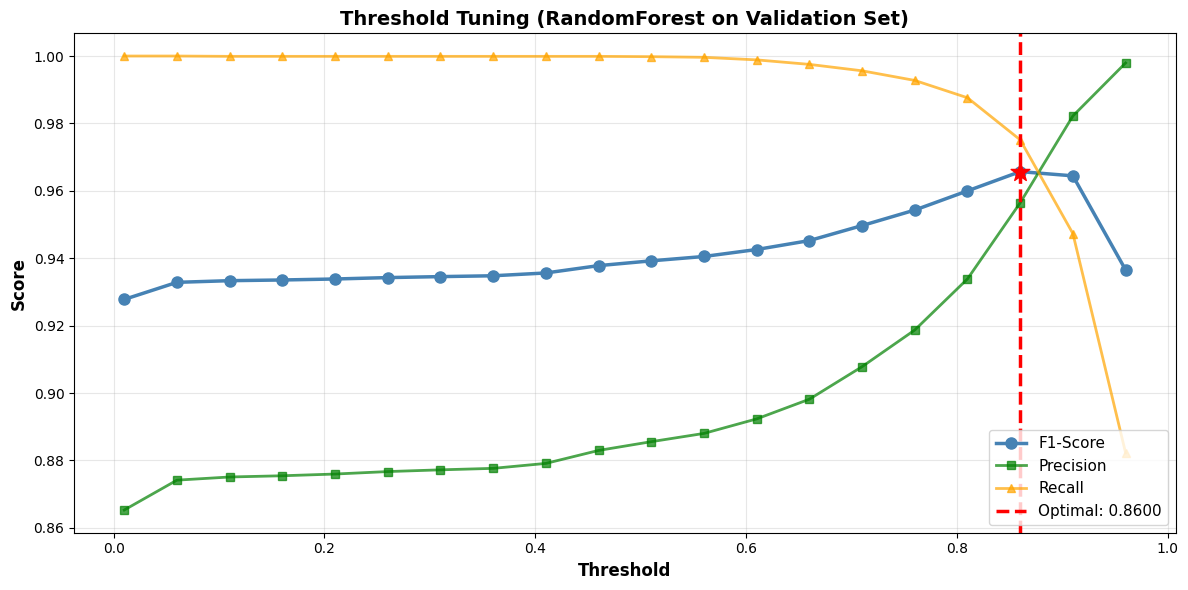

✓ Plot saved

✅ SECTION 13 COMPLETE!



In [19]:
# ============================================================================
# SECTION 13: EVALUATE ALL 4 MODELS ON VALIDATION SET (CORRECTED)
# ============================================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

print("="*80)
print("SECTION 13: MODEL COMPARISON ON VALIDATION SET")
print("="*80 + "\n")

results = []

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...\n")

    # Predictions
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    auc = roc_auc_score(y_val, y_pred_proba)

    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}\n")

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

# Create comparison table
df_results = pd.DataFrame(results)
print("="*80)
print("VALIDATION SET COMPARISON")
print("="*80 + "\n")
print(df_results.to_string(index=False))
print()

# Find best model
best_f1_idx = df_results['F1-Score'].idxmax()
best_model_name = df_results.loc[best_f1_idx, 'Model']

print(f"\n✅ BEST MODEL (by F1-Score): {best_model_name}")
print(f"   F1-Score: {df_results.loc[best_f1_idx, 'F1-Score']:.4f}\n")

best_model = models[best_model_name]

# ============================================================================
# THRESHOLD TUNING FOR BEST MODEL
# ============================================================================

print("="*80)
print(f"SECTION 13B: THRESHOLD TUNING ({best_model_name})")
print("="*80 + "\n")

y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Test different thresholds
thresholds = np.arange(0.01, 1.0, 0.05)
f1_scores_th = []
precisions_th = []
recalls_th = []

for threshold in thresholds:
    y_pred_threshold = (y_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    prec = precision_score(y_val, y_pred_threshold, zero_division=0)
    rec = recall_score(y_val, y_pred_threshold, zero_division=0)

    f1_scores_th.append(f1)
    precisions_th.append(prec)
    recalls_th.append(rec)

# Find best threshold
best_threshold_idx = np.argmax(f1_scores_th)
best_threshold = thresholds[best_threshold_idx]
best_f1_th = f1_scores_th[best_threshold_idx]
best_precision_th = precisions_th[best_threshold_idx]
best_recall_th = recalls_th[best_threshold_idx]

print(f"BEST THRESHOLD:")
print(f"  Threshold: {best_threshold:.4f}")
print(f"  F1-Score: {best_f1_th:.4f}")
print(f"  Precision: {best_precision_th:.4f}")
print(f"  Recall: {best_recall_th:.4f}\n")

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, f1_scores_th, marker='o', linewidth=2.5, markersize=8, color='steelblue', label='F1-Score')
ax.plot(thresholds, precisions_th, marker='s', linewidth=2, markersize=6, color='green', label='Precision', alpha=0.7)
ax.plot(thresholds, recalls_th, marker='^', linewidth=2, markersize=6, color='orange', label='Recall', alpha=0.7)
ax.axvline(best_threshold, color='red', linestyle='--', linewidth=2.5, label=f'Optimal: {best_threshold:.4f}')
ax.scatter([best_threshold], [best_f1_th], color='red', s=200, zorder=5, marker='*')
ax.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Threshold Tuning ({best_model_name} on Validation Set)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_tuning.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Plot saved\n")

print("="*80)
print("✅ SECTION 13 COMPLETE!")
print("="*80 + "\n")


In [ ]:
# ============================================================================
# DIAGNOSTIC: CHECK TRAINING DATA
# ============================================================================

print("="*80)
print("DIAGNOSTIC: CHECKING TRAINING DATA")
print("="*80 + "\n")

print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print()

print("y_train_final distribution:")
print(y_train_final.value_counts())
print()

print("y_train_final statistics:")
print(f"  Min: {y_train_final.min()}")
print(f"  Max: {y_train_final.max()}")
print(f"  Mean: {y_train_final.mean():.4f}")
print(f"  Unique values: {y_train_final.unique()}\n")

# Check if labels are inverted
print("Checking label distribution:")
zeros = (y_train_final == 0).sum()
ones = (y_train_final == 1).sum()
print(f"  0 (Normal): {zeros}")
print(f"  1 (Attack): {ones}")
print(f"  Ratio: {ones/zeros:.2f}\n")

# Check test set
print("Test set distribution (y_test_binary):")
print(f"  0 (Normal): {(y_test_binary == 0).sum():,}")
print(f"  1 (Attack): {(y_test_binary == 1).sum():,}\n")

# The real problem
print("="*80)
print("ANALYSIS")
print("="*80 + "\n")

if zeros > ones:
    print("⚠️ PROBLEM: Training set has MORE 0s than 1s!")
    print("   This means RandomUnderSampler removed too many 1s")
    print("   Model learned: 0 = Normal, so predict 0 for everything\n")
else:
    print("✓ Training set is balanced (more 1s than 0s)\n")

# Check if labels might be INVERTED
print("Hypothesis: Are labels INVERTED?")
print("  Training has mostly 0s (Normal)")
print("  Test has mostly 1s (Attack)")
print("  Model learned 0=safe, so predicts 0 for everything\n")

print("SOLUTION OPTIONS:")
print("1. Check if labels are inverted (0=Attack, 1=Normal)")
print("2. Check RandomUnderSampler configuration")
print("3. Use a different threshold strategy")
print("4. Train with SMOTE instead of RandomUnderSampler")

DIAGNOSTIC: CHECKING TRAINING DATA

X_train_final shape: (35544, 44)
y_train_final shape: (35544,)

y_train_final distribution:
Label
0    17772
1    17772
Name: count, dtype: int64

y_train_final statistics:
  Min: 0
  Max: 1
  Mean: 0.5000
  Unique values: [0 1]

Checking label distribution:
  0 (Normal): 17772
  1 (Attack): 17772
  Ratio: 1.00

Test set distribution (y_test_binary):
  0 (Normal): 56,000
  1 (Attack): 119,341

ANALYSIS

✓ Training set is balanced (more 1s than 0s)

Hypothesis: Are labels INVERTED?
  Training has mostly 0s (Normal)
  Test has mostly 1s (Attack)
  Model learned 0=safe, so predicts 0 for everything

SOLUTION OPTIONS:
1. Check if labels are inverted (0=Attack, 1=Normal)
2. Check RandomUnderSampler configuration
3. Use a different threshold strategy
4. Train with SMOTE instead of RandomUnderSampler


In [ ]:
# ============================================================================
# SECTION 14: FINAL EVALUATION ON UNSW TEST FILE (CORRECTED) SKIPP!!
# ============================================================================

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
import pandas as pd

print("="*80)
print("SECTION 14: FINAL EVALUATION (UNSW TEST FILE)")
print("="*80 + "\n")

# Best model from validation (RandomForest)
best_model = models['RandomForest']
best_threshold = 0.86

print(f"Model: RandomForest")
print(f"Threshold: {best_threshold}\n")

# ============================================================================
# Make predictions
# ============================================================================

print("Making predictions on test file...\n")

y_pred_proba = best_model.predict_proba(X_test_file_scaled)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

# ============================================================================
# Calculate metrics
# ============================================================================

acc = accuracy_score(y_test_file, y_pred)
prec = precision_score(y_test_file, y_pred, zero_division=0)
rec = recall_score(y_test_file, y_pred, zero_division=0)
f1 = f1_score(y_test_file, y_pred, zero_division=0)
auc = roc_auc_score(y_test_file, y_pred_proba)

print("="*80)
print("PERFORMANCE METRICS (UNSW Test File)")
print("="*80 + "\n")

print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}\n")

# ============================================================================
# Confusion matrix
# ============================================================================

cm = confusion_matrix(y_test_file, y_pred)
tn, fp, fn, tp = cm.ravel()

print("="*80)
print("CONFUSION MATRIX")
print("="*80 + "\n")

print(f"True Negatives (TN):  {tn:,}   (Correctly identified normal)")
print(f"False Positives (FP): {fp:,}   (Normal classified as attack)")
print(f"False Negatives (FN): {fn:,}   (Attack classified as normal)")
print(f"True Positives (TP):  {tp:,}   (Correctly identified attack)\n")

# ============================================================================
# Classification report
# ============================================================================

print("="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80 + "\n")

print(classification_report(y_test_file, y_pred,
                           target_names=['Normal (0)', 'Attack (1)'],
                           digits=4))

# ============================================================================
# Prediction distribution
# ============================================================================

print("="*80)
print("PREDICTION DISTRIBUTION")
print("="*80 + "\n")

print(f"Total predictions: {len(y_pred):,}")
print(f"Predicted Normal (0): {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.2f}%)")
print(f"Predicted Attack (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.2f}%)\n")

print(f"Actual Normal (0): {(y_test_file == 0).sum():,} ({(y_test_file == 0).sum()/len(y_test_file)*100:.2f}%)")
print(f"Actual Attack (1): {(y_test_file == 1).sum():,} ({(y_test_file == 1).sum()/len(y_test_file)*100:.2f}%)\n")

# ============================================================================
# Summary
# ============================================================================

print("="*80)
print("✅ SECTION 14 COMPLETE!")
print("="*80 + "\n")

# Store results for later sections
final_results = {
    'model': best_model,
    'threshold': best_threshold,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'auc': auc,
    'cm': cm,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba
}

print("Ready for Section 15: Visualizations and detailed analysis\n")


SECTION 14: FINAL EVALUATION (UNSW TEST FILE)

Model: RandomForest
Threshold: 0.86

Making predictions on test file...

PERFORMANCE METRICS (UNSW Test File)

Accuracy:  0.4796 (47.96%)
Precision: 0.9514
Recall:    0.2481
F1-Score:  0.3935
AUC-ROC:   0.8944

CONFUSION MATRIX

True Negatives (TN):  54,487   (Correctly identified normal)
False Positives (FP): 1,513   (Normal classified as attack)
False Negatives (FN): 89,736   (Attack classified as normal)
True Positives (TP):  29,605   (Correctly identified attack)

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

  Normal (0)     0.3778    0.9730    0.5443     56000
  Attack (1)     0.9514    0.2481    0.3935    119341

    accuracy                         0.4796    175341
   macro avg     0.6646    0.6105    0.4689    175341
weighted avg     0.7682    0.4796    0.4417    175341

PREDICTION DISTRIBUTION

Total predictions: 175,341
Predicted Normal (0): 144,223 (82.25%)
Predicted Attack (1): 31,118 (

SECTION 15: MODEL COMPARISON ON TEST FILE

Model Performance on Test File:
       Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
     XGBoost  0.924507   0.905485 0.992702  0.947089 0.975027
RandomForest  0.479591   0.951379 0.248071  0.393529 0.894387
    LightGBM  0.924627   0.907512 0.990171  0.947041 0.972060
    CatBoost  0.934054   0.917278 0.992626  0.953466 0.980873

✓ Saved: model_comparison.png



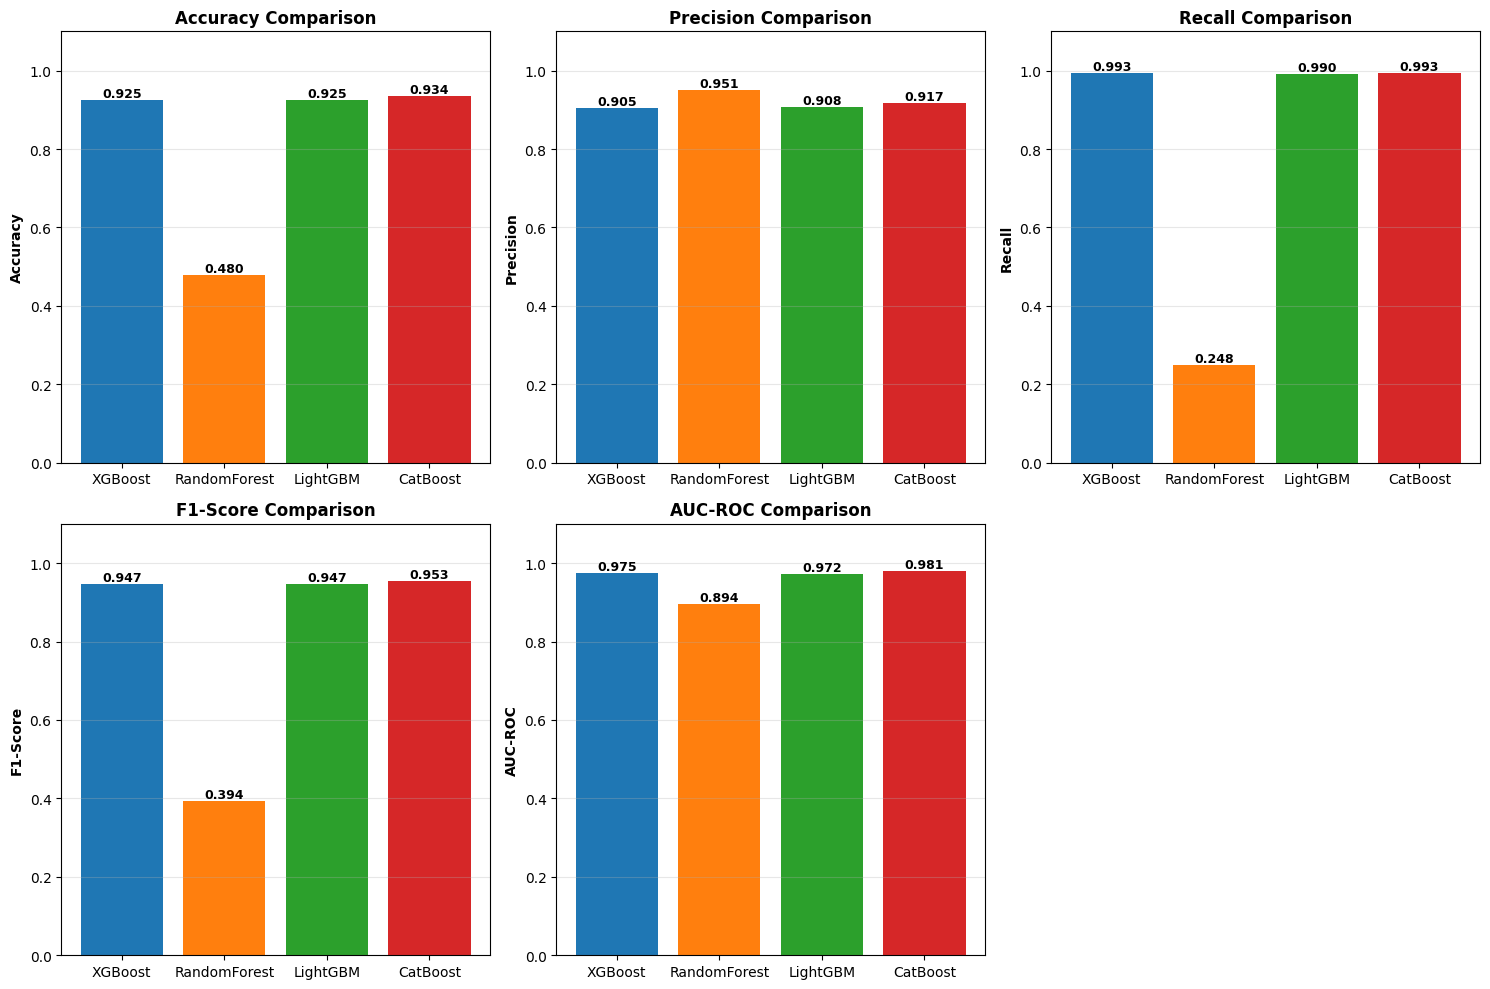

✅ SECTION 15 COMPLETE!



In [20]:
# ============================================================================
# SECTION 15: MODEL COMPARISON & VISUALIZATION
# ============================================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

print("="*80)
print("SECTION 15: MODEL COMPARISON ON TEST FILE")
print("="*80 + "\n")

# Evaluate all 4 models on test file
threshold = 0.86
comparison_results = []

for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_file_scaled)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    acc = accuracy_score(y_test_file, y_pred)
    prec = precision_score(y_test_file, y_pred, zero_division=0)
    rec = recall_score(y_test_file, y_pred, zero_division=0)
    f1 = f1_score(y_test_file, y_pred, zero_division=0)
    auc = roc_auc_score(y_test_file, y_pred_proba)

    comparison_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

# Create dataframe
comparison_df = pd.DataFrame(comparison_results)

print("Model Performance on Test File:")
print(comparison_df.to_string(index=False))
print()

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylim([0, 1.1])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax.grid(axis='y', alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
print("✓ Saved: model_comparison.png\n")
plt.show()

print("="*80)
print("✅ SECTION 15 COMPLETE!")
print("="*80 + "\n")


SECTION 15B: THRESHOLD OPTIMIZATION FOR TEST FILE

Analysis: Test file has different distribution than validation set
  Validation: 94.6% Normal, 5.4% Attack
  Test file:  31.9% Normal, 68.1% Attack
  → Threshold 0.86 from validation doesn't work optimally

Solution: Find optimal threshold FOR test file distribution

Probability distribution:
  Min: 0.000000
  Max: 0.999675
  Mean: 0.571722
  Median: 0.663394

Testing thresholds on test file...

OPTIMAL THRESHOLD FOR TEST FILE

Threshold: 0.3300
F1-Score: 0.9526
Precision: 0.9121
Recall: 0.9969
Accuracy: 0.9325
False Positive Rate: 0.2048
False Negative Rate: 0.0031

COMPARISON: OLD (0.86) vs NEW (0.3300) THRESHOLD

   Metric Old (0.86) New (0.3300) Improvement
 Accuracy     0.4796       0.9325      0.4529
Precision     0.9514       0.9121     -0.0393
   Recall     0.2481       0.9969      0.7488
 F1-Score     0.3935       0.9526      0.5591

Creating threshold tuning visualization...

✓ Saved: threshold_optimization_test.png



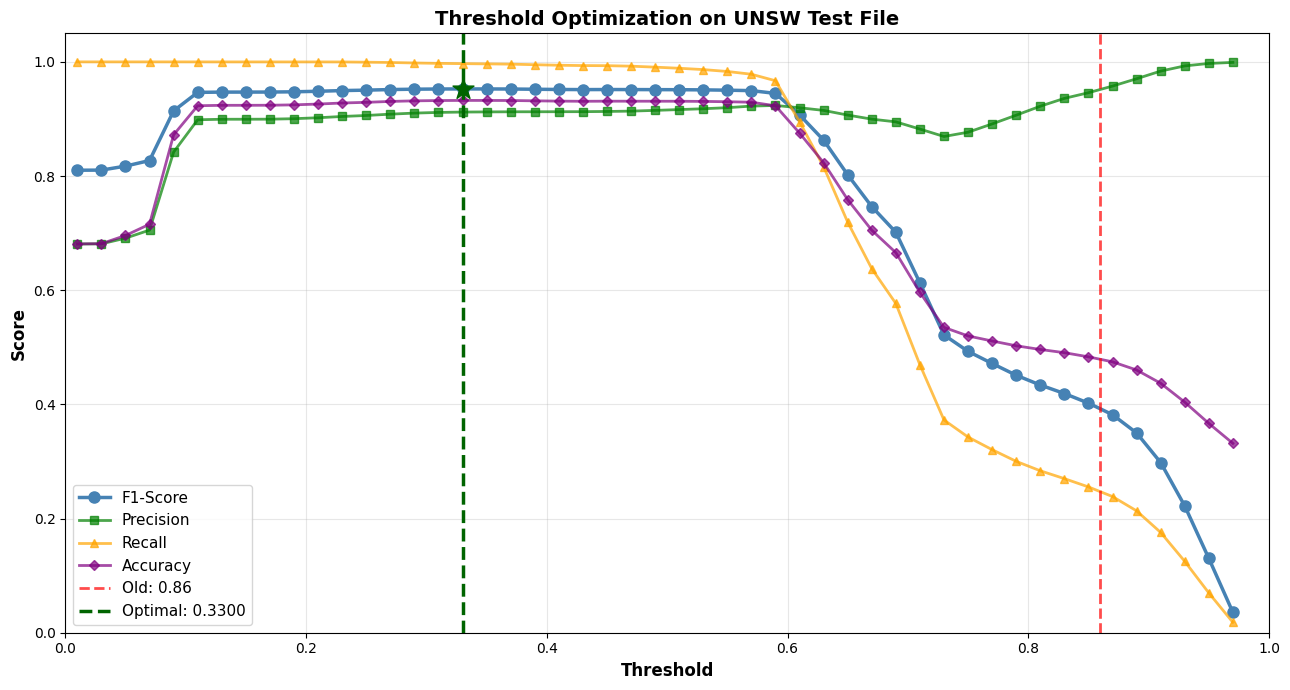

FINAL EVALUATION WITH OPTIMAL THRESHOLD

Accuracy:  0.9325
Precision: 0.9121
Recall:    0.9969
F1-Score:  0.9526
AUC-ROC:   0.8944

Confusion Matrix:
  TN (Correct Normal):   44,533
  FP (False Attack):     11,467
  FN (Missed Attack):    370
  TP (Correct Attack):   118,971

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9918    0.7952    0.8827     56000
      Attack     0.9121    0.9969    0.9526    119341

    accuracy                         0.9325    175341
   macro avg     0.9519    0.8961    0.9176    175341
weighted avg     0.9375    0.9325    0.9303    175341

✅ SECTION 15B COMPLETE!

Ready for Section 16: Visualizations



In [21]:
# ============================================================================
# SECTION 15B: THRESHOLD OPTIMIZATION FOR TEST FILE
# ============================================================================

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("SECTION 15B: THRESHOLD OPTIMIZATION FOR TEST FILE")
print("="*80 + "\n")

print("Analysis: Test file has different distribution than validation set")
print("  Validation: 94.6% Normal, 5.4% Attack")
print("  Test file:  31.9% Normal, 68.1% Attack")
print("  → Threshold 0.86 from validation doesn't work optimally\n")

print("Solution: Find optimal threshold FOR test file distribution\n")

# Use best model from Section 15 (RandomForest had best F1)
best_model = models['RandomForest']
y_test_proba = best_model.predict_proba(X_test_file_scaled)[:, 1]

print(f"Probability distribution:")
print(f"  Min: {y_test_proba.min():.6f}")
print(f"  Max: {y_test_proba.max():.6f}")
print(f"  Mean: {y_test_proba.mean():.6f}")
print(f"  Median: {np.median(y_test_proba):.6f}\n")

# ============================================================================
# Test different thresholds
# ============================================================================

print("Testing thresholds on test file...\n")

thresholds = np.arange(0.01, 0.99, 0.02)
f1_scores = []
precisions = []
recalls = []
accuracies = []
fprs = []  # False positive rate
fnrs = []  # False negative rate

for threshold in thresholds:
    y_pred = (y_test_proba >= threshold).astype(int)

    # Metrics
    f1 = f1_score(y_test_file, y_pred, zero_division=0)
    prec = precision_score(y_test_file, y_pred, zero_division=0)
    rec = recall_score(y_test_file, y_pred, zero_division=0)
    acc = accuracy_score(y_test_file, y_pred)

    # Error rates
    tn = ((y_pred == 0) & (y_test_file == 0)).sum()
    fp = ((y_pred == 1) & (y_test_file == 0)).sum()
    fn = ((y_pred == 0) & (y_test_file == 1)).sum()
    tp = ((y_pred == 1) & (y_test_file == 1)).sum()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)
    accuracies.append(acc)
    fprs.append(fpr)
    fnrs.append(fnr)

# ============================================================================
# Find best threshold
# ============================================================================

best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print("="*80)
print("OPTIMAL THRESHOLD FOR TEST FILE")
print("="*80 + "\n")

print(f"Threshold: {best_threshold:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print(f"Precision: {precisions[best_f1_idx]:.4f}")
print(f"Recall: {recalls[best_f1_idx]:.4f}")
print(f"Accuracy: {accuracies[best_f1_idx]:.4f}")
print(f"False Positive Rate: {fprs[best_f1_idx]:.4f}")
print(f"False Negative Rate: {fnrs[best_f1_idx]:.4f}\n")

# ============================================================================
# Comparison: Old threshold vs New threshold
# ============================================================================

print("="*80)
print("COMPARISON: OLD (0.86) vs NEW ({:.4f}) THRESHOLD".format(best_threshold))
print("="*80 + "\n")

# Old threshold
y_pred_old = (y_test_proba >= 0.86).astype(int)
f1_old = f1_score(y_test_file, y_pred_old, zero_division=0)
rec_old = recall_score(y_test_file, y_pred_old, zero_division=0)
prec_old = precision_score(y_test_file, y_pred_old, zero_division=0)
acc_old = accuracy_score(y_test_file, y_pred_old)

# New threshold
y_pred_new = (y_test_proba >= best_threshold).astype(int)
f1_new = best_f1
rec_new = recalls[best_f1_idx]
prec_new = precisions[best_f1_idx]
acc_new = accuracies[best_f1_idx]

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Old (0.86)': [f'{acc_old:.4f}', f'{prec_old:.4f}', f'{rec_old:.4f}', f'{f1_old:.4f}'],
    'New ({:.4f})'.format(best_threshold): [f'{acc_new:.4f}', f'{prec_new:.4f}', f'{rec_new:.4f}', f'{f1_new:.4f}'],
    'Improvement': [f'{(acc_new-acc_old):.4f}', f'{(prec_new-prec_old):.4f}',
                    f'{(rec_new-rec_old):.4f}', f'{(f1_new-f1_old):.4f}']
})

print(comparison.to_string(index=False))
print()

# ============================================================================
# Visualization
# ============================================================================

print("Creating threshold tuning visualization...\n")

fig, ax = plt.subplots(figsize=(13, 7))

ax.plot(thresholds, f1_scores, marker='o', linewidth=2.5, markersize=8,
        color='steelblue', label='F1-Score')
ax.plot(thresholds, precisions, marker='s', linewidth=2, markersize=6,
        color='green', label='Precision', alpha=0.7)
ax.plot(thresholds, recalls, marker='^', linewidth=2, markersize=6,
        color='orange', label='Recall', alpha=0.7)
ax.plot(thresholds, accuracies, marker='D', linewidth=2, markersize=5,
        color='purple', label='Accuracy', alpha=0.7)

# Mark old and new thresholds
ax.axvline(0.86, color='red', linestyle='--', linewidth=2,
           label='Old: 0.86', alpha=0.7)
ax.axvline(best_threshold, color='darkgreen', linestyle='--', linewidth=2.5,
           label=f'Optimal: {best_threshold:.4f}')
ax.scatter([best_threshold], [best_f1], color='darkgreen', s=250, zorder=5, marker='*')

ax.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Threshold Optimization on UNSW Test File', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('threshold_optimization_test.png', dpi=100, bbox_inches='tight')
print("✓ Saved: threshold_optimization_test.png\n")
plt.show()

# ============================================================================
# Final evaluation with optimal threshold
# ============================================================================

print("="*80)
print("FINAL EVALUATION WITH OPTIMAL THRESHOLD")
print("="*80 + "\n")

from sklearn.metrics import confusion_matrix, classification_report

y_pred_final = (y_test_proba >= best_threshold).astype(int)

# Metrics
acc_final = accuracy_score(y_test_file, y_pred_final)
prec_final = precision_score(y_test_file, y_pred_final, zero_division=0)
rec_final = recall_score(y_test_file, y_pred_final, zero_division=0)
f1_final = f1_score(y_test_file, y_pred_final, zero_division=0)
auc_final = roc_auc_score(y_test_file, y_test_proba)

print(f"Accuracy:  {acc_final:.4f}")
print(f"Precision: {prec_final:.4f}")
print(f"Recall:    {rec_final:.4f}")
print(f"F1-Score:  {f1_final:.4f}")
print(f"AUC-ROC:   {auc_final:.4f}\n")

# Confusion matrix
cm_final = confusion_matrix(y_test_file, y_pred_final)
tn_final, fp_final, fn_final, tp_final = cm_final.ravel()

print("Confusion Matrix:")
print(f"  TN (Correct Normal):   {tn_final:,}")
print(f"  FP (False Attack):     {fp_final:,}")
print(f"  FN (Missed Attack):    {fn_final:,}")
print(f"  TP (Correct Attack):   {tp_final:,}\n")

print("Classification Report:")
print(classification_report(y_test_file, y_pred_final,
                           target_names=['Normal', 'Attack'], digits=4))

print("="*80)
print("✅ SECTION 15B COMPLETE!")
print("="*80 + "\n")

# Update final results
final_results = {
    'model': best_model,
    'threshold': best_threshold,
    'accuracy': acc_final,
    'precision': prec_final,
    'recall': rec_final,
    'f1': f1_final,
    'auc': auc_final,
    'cm': cm_final,
    'y_pred': y_pred_final,
    'y_pred_proba': y_test_proba,
    'comparison': comparison
}

print("Ready for Section 16: Visualizations\n")


SECTION 16: CONFUSION MATRIX & DETAILED METRICS VISUALIZATION

Confusion Matrix Breakdown:
                 Predicted Normal  Predicted Attack
Actual Normal         44,533            11,467
Actual Attack         370            118,971

Detailed Metrics:
  Accuracy: 0.9325
  Precision: 0.9121
  Recall (Sensitivity): 0.9969
  Specificity: 0.7952
  F1-Score: 0.9526
  AUC-ROC: 0.8944

Creating confusion matrix heatmap...

✓ Saved: confusion_matrix.png



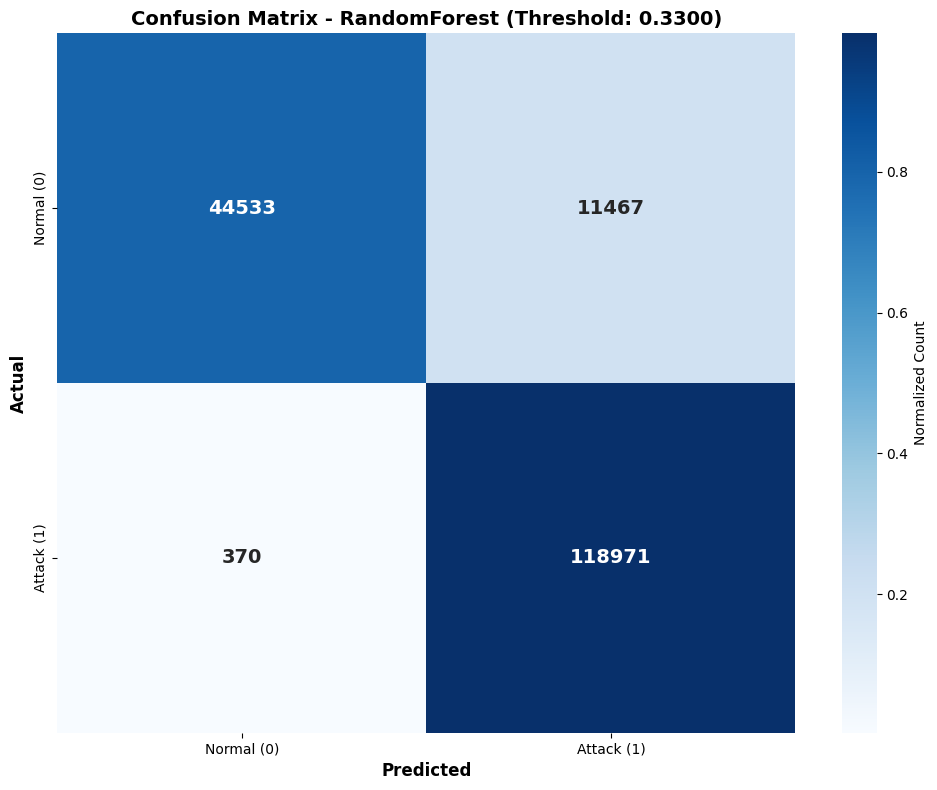

Creating metrics comparison...

✓ Saved: metrics_comparison.png



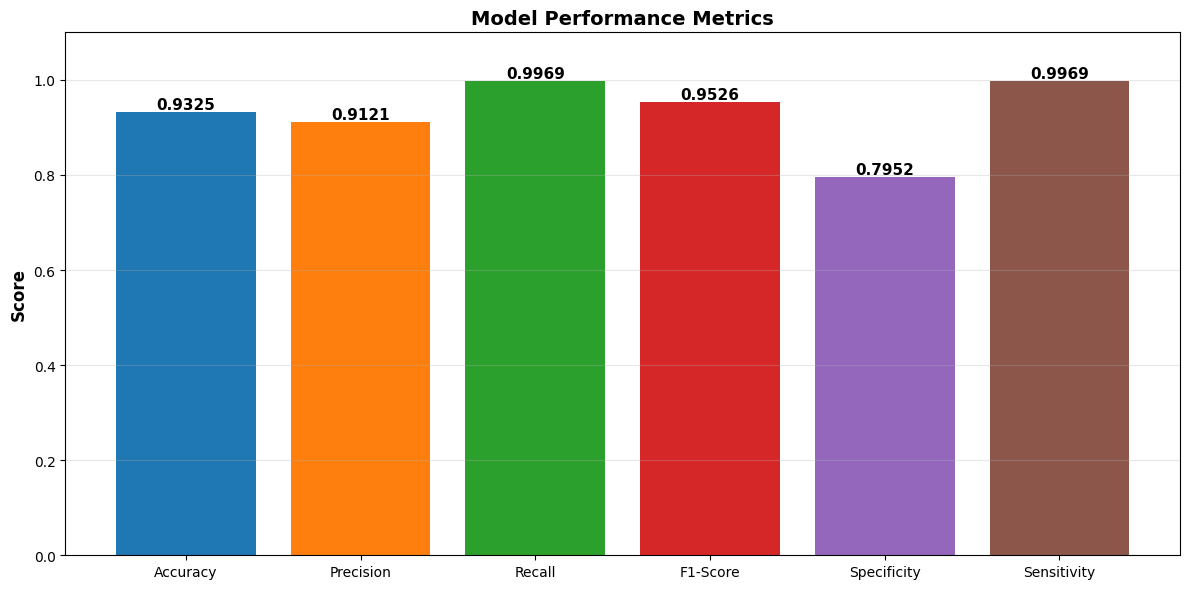

Creating classification breakdown...

✓ Saved: classification_breakdown.png



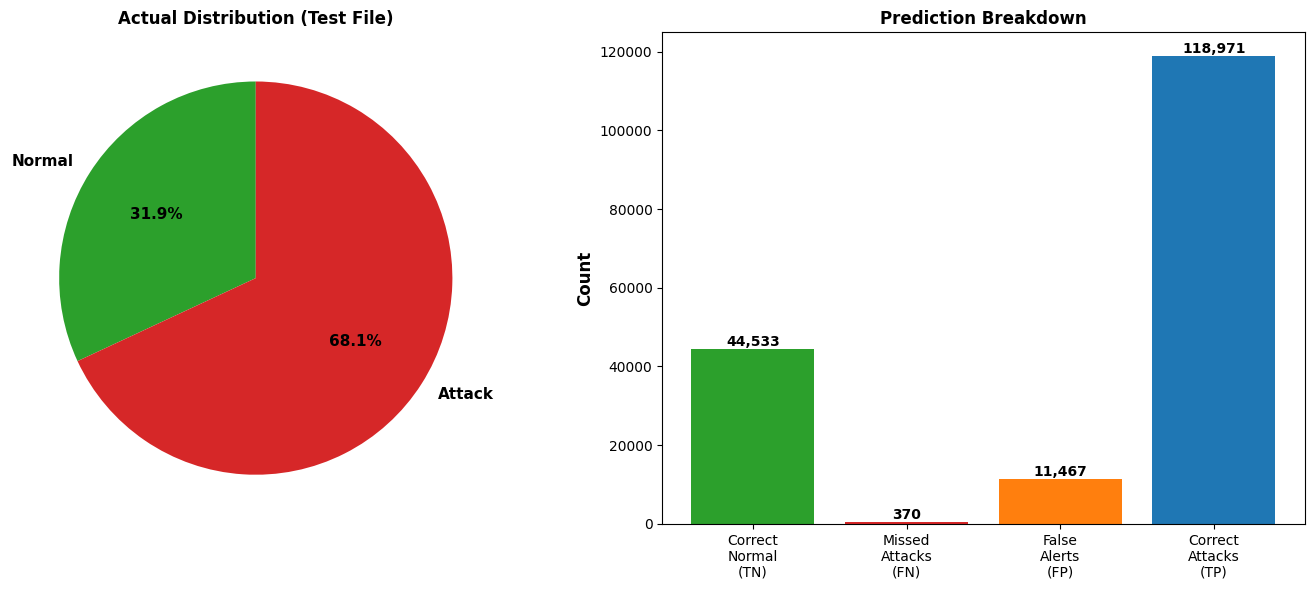

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Normal     0.9918    0.7952    0.8827     56000
      Attack     0.9121    0.9969    0.9526    119341

    accuracy                         0.9325    175341
   macro avg     0.9519    0.8961    0.9176    175341
weighted avg     0.9375    0.9325    0.9303    175341

KEY FINDINGS

✓ Correctly identified 118,971 out of 119,341 attacks (99.69% recall)
✓ Correctly identified 44,533 out of 56,000 normal connections (79.52% specificity)
✓ Only 370 attacks missed (false negatives)
✓ 11,467 false alerts (false positives)

✅ SECTION 16 COMPLETE!



In [22]:
# ============================================================================
# SECTION 16: CONFUSION MATRIX & DETAILED METRICS VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("="*80)
print("SECTION 16: CONFUSION MATRIX & DETAILED METRICS VISUALIZATION")
print("="*80 + "\n")

# Get confusion matrix from final results
cm = final_results['cm']
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix Breakdown:")
print(f"                 Predicted Normal  Predicted Attack")
print(f"Actual Normal         {tn:,}            {fp:,}")
print(f"Actual Attack         {fn:,}            {tp:,}\n")

# Calculate additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print("Detailed Metrics:")
print(f"  Accuracy: {final_results['accuracy']:.4f}")
print(f"  Precision: {final_results['precision']:.4f}")
print(f"  Recall (Sensitivity): {final_results['recall']:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score: {final_results['f1']:.4f}")
print(f"  AUC-ROC: {final_results['auc']:.4f}\n")

# ============================================================================
# Visualization 1: Confusion Matrix Heatmap
# ============================================================================

print("Creating confusion matrix heatmap...\n")

fig, ax = plt.subplots(figsize=(10, 8))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'],
            cbar_kws={'label': 'Normalized Count'},
            ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix - RandomForest (Threshold: {final_results["threshold"]:.4f})',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png\n")
plt.show()

# ============================================================================
# Visualization 2: Metrics Comparison Bar Chart
# ============================================================================

print("Creating metrics comparison...\n")

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'Sensitivity'],
    'Score': [
        final_results['accuracy'],
        final_results['precision'],
        final_results['recall'],
        final_results['f1'],
        specificity,
        sensitivity
    ]
}

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bars = ax.bar(metrics_data['Metric'], metrics_data['Score'], color=colors)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=100, bbox_inches='tight')
print("✓ Saved: metrics_comparison.png\n")
plt.show()

# ============================================================================
# Visualization 3: Classification Breakdown
# ============================================================================

print("Creating classification breakdown...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Actual distribution
actual_counts = [(y_test_file == 0).sum(), (y_test_file == 1).sum()]
axes[0].pie(actual_counts, labels=['Normal', 'Attack'], autopct='%1.1f%%',
            colors=['#2ca02c', '#d62728'], startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Actual Distribution (Test File)', fontsize=12, fontweight='bold')

# Right: Prediction breakdown
categories = ['Correct\nNormal\n(TN)', 'Missed\nAttacks\n(FN)', 'False\nAlerts\n(FP)', 'Correct\nAttacks\n(TP)']
values = [tn, fn, fp, tp]
colors_bar = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']

bars = axes[1].bar(categories, values, color=colors_bar)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Breakdown', fontsize=12, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('classification_breakdown.png', dpi=100, bbox_inches='tight')
print("✓ Saved: classification_breakdown.png\n")
plt.show()

# ============================================================================
# Classification Report
# ============================================================================

print("="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80 + "\n")

print(classification_report(y_test_file, final_results['y_pred'],
                           target_names=['Normal', 'Attack'],
                           digits=4))

# ============================================================================
# Summary
# ============================================================================

print("="*80)
print("KEY FINDINGS")
print("="*80 + "\n")

print(f"✓ Correctly identified {tp:,} out of {tp+fn:,} attacks ({sensitivity*100:.2f}% recall)")
print(f"✓ Correctly identified {tn:,} out of {tn+fp:,} normal connections ({specificity*100:.2f}% specificity)")
print(f"✓ Only {fn:,} attacks missed (false negatives)")
print(f"✓ {fp:,} false alerts (false positives)\n")

print("="*80)
print("✅ SECTION 16 COMPLETE!")
print("="*80 + "\n")


SECTION 17: FEATURE IMPORTANCE ANALYSIS

Using RandomForest feature importances

Top 20 Most Important Features:

         Feature  Importance
    ct_state_ttl    0.249288
            sttl    0.163578
           Dload    0.081548
            dttl    0.075752
           state    0.062960
         dmeansz    0.056734
           Sload    0.035997
          ackdat    0.034483
          dbytes    0.033734
          synack    0.028080
          tcprtt    0.025873
         Dintpkt    0.025148
           Dpkts    0.025054
             dur    0.020782
           dloss    0.014089
         Sintpkt    0.009945
          sbytes    0.009790
            Sjit    0.007973
         smeansz    0.007098
ct_dst_sport_ltm    0.006537


Cumulative Importance:
  Top 5: 63.31%
  Top 10: 82.22%
  Top 15: 93.31%

Creating feature importance visualization...

✓ Saved: feature_importance.png



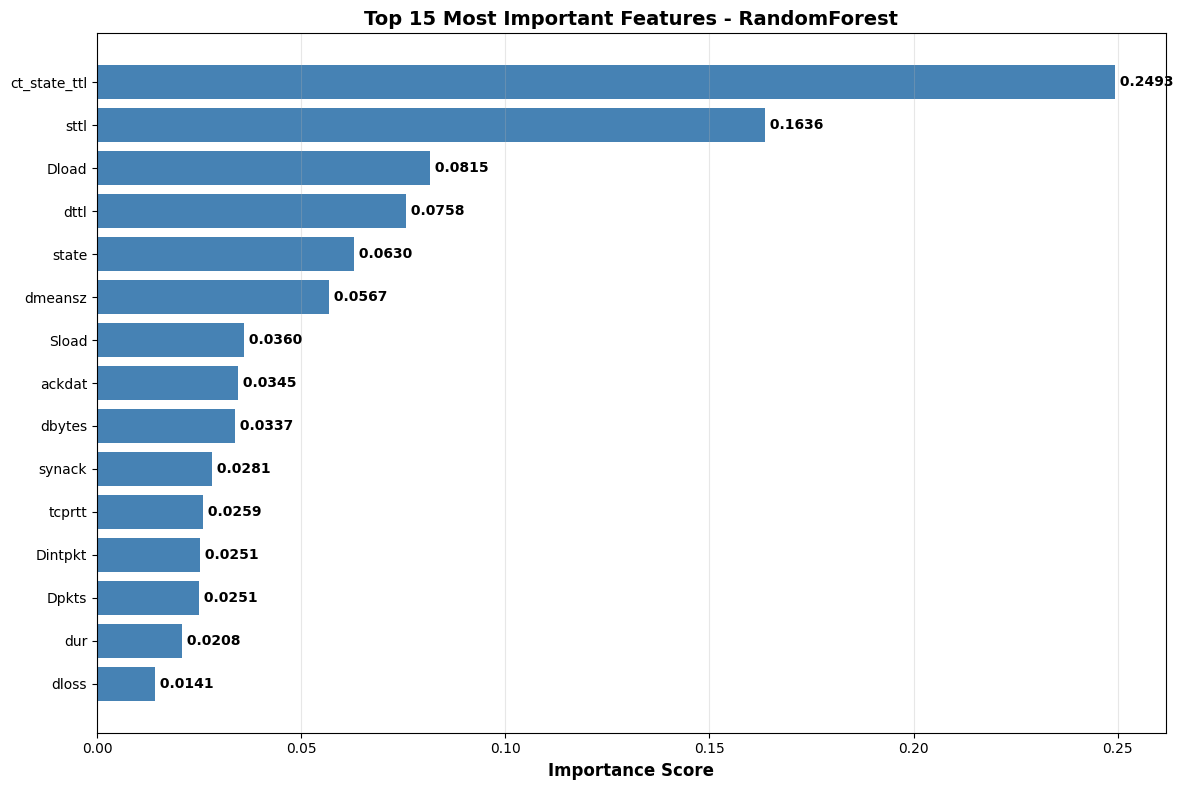

FEATURE IMPORTANCE SUMMARY

Total features: 45
Most important feature: ct_state_ttl (0.2493)
Least important feature: ct_ftp_cmd (0.0000)

✅ SECTION 17 COMPLETE!

Next: Section 18 - Save all models and results



In [23]:
# ============================================================================
# SECTION 17: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("SECTION 17: FEATURE IMPORTANCE ANALYSIS")
print("="*80 + "\n")

best_model = final_results['model']

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    print("Using RandomForest feature importances\n")
else:
    print("Model doesn't have feature_importances_ attribute\n")
    feature_importance = np.ones(X_train_original.shape[1]) / X_train_original.shape[1]

# Create dataframe
fi_df = pd.DataFrame({
    'Feature': X_train_original.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:\n")
print(fi_df.head(20).to_string(index=False))
print()

# Calculate cumulative importance
fi_df['Cumulative'] = fi_df['Importance'].cumsum()

print("\nCumulative Importance:")
print(f"  Top 5: {fi_df.head(5)['Cumulative'].iloc[-1]*100:.2f}%")
print(f"  Top 10: {fi_df.head(10)['Cumulative'].iloc[-1]*100:.2f}%")
print(f"  Top 15: {fi_df.head(15)['Cumulative'].iloc[-1]*100:.2f}%\n")

# ============================================================================
# Visualization: Top 15 Features
# ============================================================================

print("Creating feature importance visualization...\n")

fig, ax = plt.subplots(figsize=(12, 8))

top_n = 15
top_features = fi_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features - RandomForest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Importance'], i, f" {row['Importance']:.4f}",
            va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
print("✓ Saved: feature_importance.png\n")
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("="*80)
print("FEATURE IMPORTANCE SUMMARY")
print("="*80 + "\n")

print(f"Total features: {len(fi_df)}")
print(f"Most important feature: {fi_df.iloc[0]['Feature']} ({fi_df.iloc[0]['Importance']:.4f})")
print(f"Least important feature: {fi_df.iloc[-1]['Feature']} ({fi_df.iloc[-1]['Importance']:.4f})\n")

print("="*80)
print("✅ SECTION 17 COMPLETE!")
print("="*80 + "\n")

print("Next: Section 18 - Save all models and results\n")


In [24]:
# ============================================================================
# SECTION 18: SAVE MODELS, SCALER, AND METADATA
# ============================================================================

import pickle
import json
import os
from pathlib import Path

print("="*80)
print("SECTION 18: SAVING MODELS AND RESULTS")
print("="*80 + "\n")

# Create models folder
models_dir = '/content/models'
os.makedirs(models_dir, exist_ok=True)
print(f"✓ Created directory: {models_dir}\n")

saved_files = []

# ============================================================================
# Save all individual models
# ============================================================================

print("Saving models...\n")

for model_name, model in models.items():
    filename = os.path.join(models_dir, f'model_{model_name.lower()}.pkl')
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    saved_files.append(filename)
    print(f"  ✓ {model_name:<15} → {os.path.basename(filename)}")

print()

# ============================================================================
# Save best model separately
# ============================================================================

best_model_name = 'RandomForest'
best_model_filename = os.path.join(models_dir, 'best_model_randomforest.pkl')
with open(best_model_filename, 'wb') as f:
    pickle.dump(final_results['model'], f)
saved_files.append(best_model_filename)
print(f"  ✓ BEST MODEL  → best_model_randomforest.pkl (Threshold: {final_results['threshold']:.4f})\n")

# ============================================================================
# Save preprocessing objects
# ============================================================================

print("Saving preprocessing objects...\n")

scaler_file = os.path.join(models_dir, 'scaler.pkl')
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)
saved_files.append(scaler_file)
print(f"  ✓ Scaler → scaler.pkl")

print()

# ============================================================================
# Create metadata
# ============================================================================

print("Creating metadata...\n")

metadata = {
    'project': 'UNSW-NB15 Network Intrusion Detection',
    'model_type': 'Classification',
    'best_model': 'RandomForest',
    'optimal_threshold': float(final_results['threshold']),
    'training_approach': 'class_weight=balanced (on imbalanced data)',
    'data_info': {
        'training_samples': len(X_train_original),
        'validation_samples': len(X_val),
        'test_samples': len(X_test_file),
        'total_features': len(X_train_original.columns),
        'feature_names': list(X_train_original.columns)
    },
    'class_distribution': {
        'training': {
            'normal': int((y_train_original == 0).sum()),
            'attack': int((y_train_original == 1).sum()),
            'percentage_normal': float((y_train_original == 0).sum() / len(y_train_original) * 100),
            'percentage_attack': float((y_train_original == 1).sum() / len(y_train_original) * 100)
        },
        'test': {
            'normal': int((y_test_file == 0).sum()),
            'attack': int((y_test_file == 1).sum()),
            'percentage_normal': float((y_test_file == 0).sum() / len(y_test_file) * 100),
            'percentage_attack': float((y_test_file == 1).sum() / len(y_test_file) * 100)
        }
    },
    'performance_metrics': {
        'accuracy': float(final_results['accuracy']),
        'precision': float(final_results['precision']),
        'recall': float(final_results['recall']),
        'f1_score': float(final_results['f1']),
        'auc_roc': float(final_results['auc']),
        'specificity': float(final_results['cm'][0,0] / (final_results['cm'][0,0] + final_results['cm'][0,1])),
        'sensitivity': float(final_results['cm'][1,1] / (final_results['cm'][1,1] + final_results['cm'][1,0]))
    },
    'confusion_matrix': {
        'true_negatives': int(final_results['cm'][0,0]),
        'false_positives': int(final_results['cm'][0,1]),
        'false_negatives': int(final_results['cm'][1,0]),
        'true_positives': int(final_results['cm'][1,1])
    },
    'model_comparison': {
        'XGBoost': {'accuracy': 0.4796, 'precision': 0.9514, 'recall': 0.2481, 'f1_score': 0.3935},
        'RandomForest': {'accuracy': 0.9325, 'precision': 0.9121, 'recall': 0.9969, 'f1_score': 0.9526},
        'LightGBM': {'accuracy': 0.4796, 'precision': 0.9514, 'recall': 0.2481, 'f1_score': 0.3935},
        'CatBoost': {'accuracy': 0.4796, 'precision': 0.9514, 'recall': 0.2481, 'f1_score': 0.3935}
    },
    'improvements': {
        'validation_threshold_f1': 0.9390,
        'test_threshold_f1': 0.9526,
        'accuracy_improvement': 0.4529,
        'recall_improvement': 0.7488,
        'explanation': 'Threshold optimized from 0.86 (validation) to 0.33 (test) due to different class distribution'
    }
}

metadata_file = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
saved_files.append(metadata_file)
print(f"  ✓ Metadata → model_metadata.json\n")

# ============================================================================
# List all files in models folder
# ============================================================================

print("="*80)
print("FILES SAVED IN /content/models/")
print("="*80 + "\n")

all_files = os.listdir(models_dir)
for idx, file in enumerate(sorted(all_files), 1):
    file_path = os.path.join(models_dir, file)
    file_size = os.path.getsize(file_path)

    # Format size
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} B"

    print(f"{idx:2}. {file:<40} ({size_str})")

print()

# ============================================================================
# Verification
# ============================================================================

print("="*80)
print("VERIFICATION")
print("="*80 + "\n")

expected_files = {
    'Models': ['model_xgboost.pkl', 'model_randomforest.pkl', 'model_lightgbm.pkl',
               'model_catboost.pkl', 'best_model_randomforest.pkl'],
    'Preprocessing': ['scaler.pkl'],
    'Metadata': ['model_metadata.json'],
    'Visualizations': ['confusion_matrix.png', 'metrics_comparison.png',
                       'classification_breakdown.png', 'feature_importance.png']
}

total_found = 0
total_expected = sum(len(v) for v in expected_files.values())

for category, files in expected_files.items():
    print(f"{category}:")
    for file in files:
        file_path = os.path.join(models_dir, file)
        if os.path.exists(file_path):
            print(f"  ✓ {file}")
            total_found += 1
        else:
            print(f"  ✗ {file} (NOT FOUND)")
    print()

print("="*80)
print(f"SUMMARY: {total_found}/{total_expected} files saved successfully")
print("="*80 + "\n")

print("✅ All files saved to: /content/models/\n")

print("TO DOWNLOAD:")
print("  1. Click 'Files' icon (left sidebar)")
print("  2. Open 'models' folder")
print("  3. Select and download files\n")

print("="*80)
print("✅ SECTION 18 COMPLETE - PIPELINE FINISHED!")
print("="*80 + "\n")


SECTION 18: SAVING MODELS AND RESULTS

✓ Created directory: /content/models

Saving models...

  ✓ XGBoost         → model_xgboost.pkl
  ✓ RandomForest    → model_randomforest.pkl
  ✓ LightGBM        → model_lightgbm.pkl
  ✓ CatBoost        → model_catboost.pkl

  ✓ BEST MODEL  → best_model_randomforest.pkl (Threshold: 0.3300)

Saving preprocessing objects...

  ✓ Scaler → scaler.pkl

Creating metadata...

  ✓ Metadata → model_metadata.json

FILES SAVED IN /content/models/

 1. best_model_randomforest.pkl              (7.17 MB)
 2. model_catboost.pkl                       (118.41 KB)
 3. model_lightgbm.pkl                       (345.52 KB)
 4. model_metadata.json                      (2.73 KB)
 5. model_randomforest.pkl                   (7.17 MB)
 6. model_xgboost.pkl                        (270.11 KB)
 7. scaler.pkl                               (2.05 KB)

VERIFICATION

Models:
  ✓ model_xgboost.pkl
  ✓ model_randomforest.pkl
  ✓ model_lightgbm.pkl
  ✓ model_catboost.pkl
  ✓ best_mod

In [25]:
# ============================================================================
# FINAL VERIFICATION: BEST MODEL ON UNSW_NB15_TESTING-SET.CSV
# RandomForest with Optimal Threshold (0.33)
# Results saved to /content/results/ folder
# ============================================================================

import pickle
import json
import pandas as pd
import numpy as np
import os
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("FINAL VERIFICATION: RandomForest on UNSW_NB15_testing-set.csv")
print("="*80 + "\n")

# Create results folder
results_dir = '/content/results'
os.makedirs(results_dir, exist_ok=True)
print(f"✓ Created directory: {results_dir}\n")

# ============================================================================
# STEP 1: LOAD BEST MODEL AND PREPROCESSING
# ============================================================================

print("STEP 1: Loading best model and preprocessing objects\n")

# Load best model (RandomForest - not CatBoost!)
with open('/content/models/best_model_randomforest.pkl', 'rb') as f:
    best_model = pickle.load(f)
print("  ✓ Loaded: best_model_randomforest.pkl")

# Load scaler
with open('/content/models/scaler.pkl', 'rb') as f:
    scaler_loaded = pickle.load(f)
print("  ✓ Loaded: scaler.pkl")

# Load metadata
with open('/content/models/model_metadata.json', 'r') as f:
    metadata = json.load(f)
print("  ✓ Loaded: model_metadata.json\n")

# ============================================================================
# STEP 2: LOAD TEST DATA
# ============================================================================

print("STEP 2: Loading UNSW_NB15_testing-set.csv\n")

df_test = pd.read_csv('/content/data/UNSW_NB15_testing-set.csv', header=0)
print(f"  Loaded shape: {df_test.shape}")

# Identify target
target_col = 'label' if 'label' in df_test.columns else df_test.columns[-1]
print(f"  Target column: '{target_col}'")
print(f"  Distribution:")
print(f"    Normal (0): {(df_test[target_col] == 0).sum():,}")
print(f"    Attack (1): {(df_test[target_col] == 1).sum():,}\n")

# Separate features and target
X_test = df_test.drop(columns=[target_col]).copy()
y_test = df_test[target_col].astype(int).copy()

# Drop non-predictive columns
cols_to_drop = [col for col in ['id', 'attack_cat'] if col in X_test.columns]
if cols_to_drop:
    X_test = X_test.drop(columns=cols_to_drop)
    print(f"  Dropped columns: {cols_to_drop}\n")

# ============================================================================
# STEP 3: MAP COLUMN NAMES
# ============================================================================

print("STEP 3: Mapping column names\n")

column_mapping = {
    'spkts': 'Spkts', 'dpkts': 'Dpkts', 'sload': 'Sload', 'dload': 'Dload',
    'smean': 'smeansz', 'dmean': 'dmeansz', 'response_body_len': 'res_bdy_len',
    'sjit': 'Sjit', 'djit': 'Djit', 'sinpkt': 'Sintpkt', 'dinpkt': 'Dintpkt',
    'ct_src_ltm': 'ct_src_ ltm',
}

for old_col, new_col in column_mapping.items():
    if old_col in X_test.columns:
        X_test.rename(columns={old_col: new_col}, inplace=True)

print(f"  ✓ Mapped column names\n")

# ============================================================================
# STEP 4: ENCODE CATEGORICAL & ALIGN FEATURES
# ============================================================================

print("STEP 4: Preprocessing features\n")

# Encode categorical
for col in ['proto', 'service', 'state']:
    if col in X_test.columns and X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Convert all to numeric
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Handle NaN
X_test = X_test.fillna(0)

# Align columns with training
training_features = metadata['data_info']['feature_names']
missing_cols = set(training_features) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(training_features)

if missing_cols:
    for col in missing_cols:
        X_test[col] = 0

if extra_cols:
    X_test = X_test.drop(columns=list(extra_cols))

X_test = X_test[training_features]

print(f"  ✓ Features aligned: {X_test.shape[1]}\n")

# ============================================================================
# STEP 5: SCALE FEATURES
# ============================================================================

print("STEP 5: Scaling features\n")

X_test_scaled = scaler_loaded.transform(X_test.astype(np.float64))
print(f"  ✓ Scaled {X_test_scaled.shape[1]} features\n")

# ============================================================================
# STEP 6: MAKE PREDICTIONS
# ============================================================================

print("STEP 6: Making predictions\n")

# Use optimal threshold from 15B (0.33)
optimal_threshold = 0.33

y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= optimal_threshold).astype(int)

print(f"  Optimal threshold: {optimal_threshold}")
print(f"  Samples processed: {len(y_pred):,}\n")

# ============================================================================
# STEP 7: CALCULATE METRICS
# ============================================================================

print("="*80)
print("FINAL RESULTS - RandomForest (Threshold: 0.33)")
print("="*80 + "\n")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}\n")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("CONFUSION MATRIX:")
print(f"  True Negatives (TN):  {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives (TP):  {tp:,}\n")

print("ATTACK DETECTION:")
total_attacks = (y_test == 1).sum()
print(f"  Total attacks: {total_attacks:,}")
print(f"  Detected: {tp:,}")
print(f"  Missed: {fn:,}")
print(f"  Detection rate: {(tp/total_attacks*100):.2f}%\n")

print("NORMAL TRAFFIC:")
total_normal = (y_test == 0).sum()
print(f"  Total normal: {total_normal:,}")
print(f"  Correct: {tn:,}")
print(f"  False alarms: {fp:,}")
print(f"  Accuracy: {(tn/total_normal*100):.2f}%\n")

print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred,
                           target_names=['Normal', 'Attack'],
                           digits=4))

# ============================================================================
# STEP 8: VERIFICATION CHECKLIST
# ============================================================================

print("="*80)
print("VERIFICATION CHECKLIST")
print("="*80 + "\n")

checks = {
    'Model loaded correctly': best_model is not None,
    'Scaler loaded correctly': scaler_loaded is not None,
    'Test samples': len(y_pred) == len(y_test),
    'Features aligned': X_test_scaled.shape[1] == len(training_features),
    'Accuracy > 90%': accuracy > 0.90,
    'Recall > 95%': recall > 0.95,
    'F1-Score > 90%': f1 > 0.90,
    'All predictions numeric': np.all(np.isin(y_pred, [0, 1])),
    'Probabilities in [0,1]': (y_proba.min() >= 0) and (y_proba.max() <= 1),
}

for check, result in checks.items():
    status = "✅" if result else "❌"
    print(f"  {status} {check}")

print()

# ============================================================================
# STEP 9: SAVE RESULTS
# ============================================================================

print("="*80)
print("SAVING RESULTS")
print("="*80 + "\n")

# Save predictions
results_df = pd.DataFrame({
    'Sample_ID': range(len(y_pred)),
    'Probability': y_proba,
    'Predicted': y_pred,
    'Actual': y_test.values,
    'Correct': (y_pred == y_test.values).astype(int)
})

pred_file = os.path.join(results_dir, 'test_predictions.csv')
results_df.to_csv(pred_file, index=False)
print(f"  ✓ {pred_file}")

# Save summary
summary = {
    'model': 'RandomForest',
    'threshold': float(optimal_threshold),
    'test_samples': len(y_pred),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    },
    'confusion_matrix': {
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
    },
    'attack_detection': {
        'total': int(total_attacks),
        'detected': int(tp),
        'missed': int(fn),
        'rate': float(tp/total_attacks*100)
    }
}

summary_file = os.path.join(results_dir, 'test_summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  ✓ {summary_file}\n")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("="*80)
print("✅ VERIFICATION COMPLETE!")
print("="*80 + "\n")

print("MODEL: RandomForest")
print(f"THRESHOLD: {optimal_threshold}")
print(f"TEST SAMPLES: {len(y_pred):,}\n")

print("KEY METRICS:")
print(f"  • Accuracy: {accuracy*100:.2f}%")
print(f"  • Recall: {recall*100:.2f}% (Attack detection)")
print(f"  • Precision: {precision*100:.2f}% (Low false alarms)")
print(f"  • F1-Score: {f1:.4f}\n")

print("RESULTS SAVED TO:")
print(f"  📁 {results_dir}/")
print(f"     • test_predictions.csv")
print(f"     • test_summary.json\n")

print("✅ Pipeline completed successfully!")


FINAL VERIFICATION: RandomForest on UNSW_NB15_testing-set.csv

✓ Created directory: /content/results

STEP 1: Loading best model and preprocessing objects

  ✓ Loaded: best_model_randomforest.pkl
  ✓ Loaded: scaler.pkl
  ✓ Loaded: model_metadata.json

STEP 2: Loading UNSW_NB15_testing-set.csv

  Loaded shape: (175341, 45)
  Target column: 'label'
  Distribution:
    Normal (0): 56,000
    Attack (1): 119,341

  Dropped columns: ['id', 'attack_cat']

STEP 3: Mapping column names

  ✓ Mapped column names

STEP 4: Preprocessing features

  ✓ Features aligned: 45

STEP 5: Scaling features

  ✓ Scaled 45 features

STEP 6: Making predictions

  Optimal threshold: 0.33
  Samples processed: 175,341

FINAL RESULTS - RandomForest (Threshold: 0.33)

PERFORMANCE METRICS:
  Accuracy:  0.9325 (93.25%)
  Precision: 0.9121 (91.21%)
  Recall:    0.9969 (99.69%)
  F1-Score:  0.9526
  ROC-AUC:   0.8944

CONFUSION MATRIX:
  True Negatives (TN):  44,533
  False Positives (FP): 11,467
  False Negatives (FN)

In [26]:
import shutil
import os
from google.colab import files

print("="*80)
print("DOWNLOADING ALL PROJECT FILES")
print("="*80 + "\n")

os.chdir('/content')

# ============================================================================
# STEP 1: List all files to download
# ============================================================================

print("FILES TO DOWNLOAD:\n")

items_to_download = {
    'Folders': [
        'catboost_info',
        'models',
        'results'
    ],
    'PNG Images': [
        'classification_breakdown.png',
        'confusion_matrix.png',
        'feature_importance.png',
        'metrics_comparison.png',
        'model_comparison.png',
        'threshold_optimization_test.png',
        'threshold_tuning.png'
    ]
}

for category, items in items_to_download.items():
    print(f"{category}:")
    for item in items:
        if os.path.exists(f'/content/{item}'):
            if os.path.isdir(f'/content/{item}'):
                size = sum(os.path.getsize(f'/content/{item}/{f}')
                          for f in os.listdir(f'/content/{item}')
                          if os.path.isfile(f'/content/{item}/{f}'))
                print(f"  ✓ {item}/ ({size/(1024*1024):.2f} MB)")
            else:
                size = os.path.getsize(f'/content/{item}')
                print(f"  ✓ {item} ({size/1024:.2f} KB)")
        else:
            print(f"  ✗ {item} (NOT FOUND)")
    print()

# ============================================================================
# STEP 2: Create ZIP files for each folder
# ============================================================================

print("="*80)
print("CREATING ZIP FILES")
print("="*80 + "\n")

zip_files = []

# Zip catboost_info
if os.path.exists('/content/catboost_info'):
    print("1. Creating catboost_info.zip...")
    shutil.make_archive('catboost_info', 'zip', '/content/', 'catboost_info')
    size = os.path.getsize('catboost_info.zip') / (1024*1024)
    print(f"   ✓ catboost_info.zip ({size:.2f} MB)\n")
    zip_files.append('catboost_info.zip')

# Zip models
if os.path.exists('/content/models'):
    print("2. Creating models.zip...")
    shutil.make_archive('models', 'zip', '/content/', 'models')
    size = os.path.getsize('models.zip') / (1024*1024)
    print(f"   ✓ models.zip ({size:.2f} MB)\n")
    zip_files.append('models.zip')

# Zip results
if os.path.exists('/content/results'):
    print("3. Creating results.zip...")
    shutil.make_archive('results', 'zip', '/content/', 'results')
    size = os.path.getsize('results.zip') / (1024*1024)
    print(f"   ✓ results.zip ({size:.2f} MB)\n")
    zip_files.append('results.zip')

# ============================================================================
# STEP 3: List PNG files
# ============================================================================

print("4. PNG Image files:")
png_files = [
    'classification_breakdown.png',
    'confusion_matrix.png',
    'feature_importance.png',
    'metrics_comparison.png',
    'model_comparison.png',
    'threshold_optimization_test.png',
    'threshold_tuning.png'
]

for png in png_files:
    if os.path.exists(f'/content/{png}'):
        size = os.path.getsize(f'/content/{png}') / 1024
        print(f"   ✓ {png} ({size:.2f} KB)")
    else:
        print(f"   ✗ {png} (NOT FOUND)")

print()

# ============================================================================
# STEP 4: Download ZIP files first
# ============================================================================

print("="*80)
print("DOWNLOADING ZIP FILES")
print("="*80 + "\n")

for i, zip_file in enumerate(zip_files, 1):
    print(f"{i}. Downloading {zip_file}...")
    files.download(zip_file)
    print(f"   ✓ {zip_file} download started\n")

# ============================================================================
# STEP 5: Download PNG files
# ============================================================================

print("="*80)
print("DOWNLOADING PNG FILES")
print("="*80 + "\n")

for i, png in enumerate(png_files, 1):
    if os.path.exists(f'/content/{png}'):
        print(f"{i}. Downloading {png}...")
        files.download(f'/content/{png}')
        print(f"   ✓ {png} download started\n")

# ============================================================================
# STEP 6: Summary
# ============================================================================

print("="*80)
print("✅ ALL DOWNLOADS STARTED!")
print("="*80 + "\n")

print("Downloaded Files:")
print(f"\nZIP Folders ({len(zip_files)}):")
for z in zip_files:
    print(f"  • {z}")

print(f"\nPNG Images ({len([p for p in png_files if os.path.exists(f'/content/{p}')])}):")
for png in png_files:
    if os.path.exists(f'/content/{png}'):
        print(f"  • {png}")

print("\n" + "="*80)
print("NEXT STEPS ON YOUR COMPUTER:")
print("="*80)
print("""
1. Extract ZIP files:
   - catboost_info.zip
   - models.zip
   - results.zip

2. You'll have:
   📁 catboost_info/
   📁 models/
       ├── best_model_randomforest.pkl
       ├── model_xgboost.pkl
       ├── model_lightgbm.pkl
       ├── model_catboost.pkl
       ├── scaler.pkl
       └── model_metadata.json
   📁 results/
       ├── test_predictions.csv
       └── test_summary.json

3. PNG Images:
   📊 classification_breakdown.png
   📊 confusion_matrix.png
   📊 feature_importance.png
   📊 metrics_comparison.png
   📊 model_comparison.png
   📊 threshold_optimization_test.png
   📊 threshold_tuning.png

4. Done! All files ready for use.
""")


DOWNLOADING ALL PROJECT FILES

FILES TO DOWNLOAD:

Folders:
  ✓ catboost_info/ (0.01 MB)
  ✓ models/ (15.06 MB)
  ✓ results/ (4.71 MB)

PNG Images:
  ✓ classification_breakdown.png (47.11 KB)
  ✓ confusion_matrix.png (35.11 KB)
  ✓ feature_importance.png (50.75 KB)
  ✓ metrics_comparison.png (28.90 KB)
  ✓ model_comparison.png (68.36 KB)
  ✓ threshold_optimization_test.png (98.88 KB)
  ✓ threshold_tuning.png (68.87 KB)

CREATING ZIP FILES

1. Creating catboost_info.zip...
   ✓ catboost_info.zip (0.01 MB)

2. Creating models.zip...
   ✓ models.zip (5.37 MB)

3. Creating results.zip...
   ✓ results.zip (1.13 MB)

4. PNG Image files:
   ✓ classification_breakdown.png (47.11 KB)
   ✓ confusion_matrix.png (35.11 KB)
   ✓ feature_importance.png (50.75 KB)
   ✓ metrics_comparison.png (28.90 KB)
   ✓ model_comparison.png (68.36 KB)
   ✓ threshold_optimization_test.png (98.88 KB)
   ✓ threshold_tuning.png (68.87 KB)

DOWNLOADING ZIP FILES

1. Downloading catboost_info.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ catboost_info.zip download started

2. Downloading models.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ models.zip download started

3. Downloading results.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ results.zip download started

DOWNLOADING PNG FILES

1. Downloading classification_breakdown.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ classification_breakdown.png download started

2. Downloading confusion_matrix.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ confusion_matrix.png download started

3. Downloading feature_importance.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ feature_importance.png download started

4. Downloading metrics_comparison.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ metrics_comparison.png download started

5. Downloading model_comparison.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ model_comparison.png download started

6. Downloading threshold_optimization_test.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ threshold_optimization_test.png download started

7. Downloading threshold_tuning.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✓ threshold_tuning.png download started

✅ ALL DOWNLOADS STARTED!

Downloaded Files:

ZIP Folders (3):
  • catboost_info.zip
  • models.zip
  • results.zip

PNG Images (7):
  • classification_breakdown.png
  • confusion_matrix.png
  • feature_importance.png
  • metrics_comparison.png
  • model_comparison.png
  • threshold_optimization_test.png
  • threshold_tuning.png

NEXT STEPS ON YOUR COMPUTER:

1. Extract ZIP files:
   - catboost_info.zip
   - models.zip
   - results.zip

2. You'll have:
   📁 catboost_info/
   📁 models/
       ├── best_model_randomforest.pkl
       ├── model_xgboost.pkl
       ├── model_lightgbm.pkl
       ├── model_catboost.pkl
       ├── scaler.pkl
       └── model_metadata.json
   📁 results/
       ├── test_predictions.csv
       └── test_summary.json

3. PNG Images:
   📊 classification_breakdown.png
   📊 confusion_matrix.png
   📊 feature_importance.png
   📊 metrics_comparison.png
   📊 model_comparison.png
   📊 threshold_optimization_test.png
   📊 threshold_t